Predecir la cantidad de ovocitos aspirados (ASPIRADOS_TOTAL) en pacientes, usando como variables predictoras la edad, AMH, FSH, AFC, dosis, duración de estimulación y tipo de gonadotropinas utilizadas.

In [ ]:
                                                      #INSTALAMOS LAS LIBRERIAS NECESARIAS
# Cargamos las librerías esenciales para el análisis de datos y el modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [ ]:
data = pd.read_excel("/content/solo pacientes.xlsx")

data.head(5)

,Link,Inicio prot,OvocitoNumero.-,SEXO_OK_MUJER,ETIOLOGIA_OK_MUJER,Etiología femenina normal,Edad materna avanzada,Alteración ovárica,Alteración tubárica,Alteración uterina,...,ESDFul.N2 Maximum Flow,ESDFul.N2 Flow Deviation,ESDFul.N2 Average Pressure,ESDFul.N2 Minimum Pressure,ESDFul.N2 Maximum Pressure,ESDFul.N2 Pressure Deviation,ESDFul.Temperature Average,ESDFul.Temperature Minimum,ESDFul.Temperature Maximum,ESDFul.Temperature Deviation
0,2160800,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,37.051,37.04,37.06,0.005
1,2160800,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,37.051,37.04,37.06,0.005
2,2160800,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,37.051,37.04,37.06,0.005
3,2160800,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,37.051,37.04,37.06,0.005
4,2160800,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,37.051,37.04,37.06,0.005


In [ ]:
# Seleccionar la correlación con la variable objetivo
# Calcular la matriz de correlación con las variables numéricas
correlation_matrix = data.corr(numeric_only=True)

target_corr = correlation_matrix["ASPIRADOS_TOTAL"].drop("ASPIRADOS_TOTAL")  # Excluye a sí misma

# Ordenar por fuerza de correlación (de mayor a menor, absolutas)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Mostrar solo las más fuertes (por ejemplo, mayores a 0.3 o menores a -0.3)
strong_corr = target_corr_sorted[(target_corr_sorted >= 0.3) | (target_corr_sorted <= -0.3)]

print("Variables con mayor correlación positiva o negativa con ASPIRADOS_TOTAL:\n")
print(strong_corr)


Variables con mayor correlación positiva o negativa con ASPIRADOS_TOTAL:

N_OVO_ASPIRADOS_IN.-_OK            1.000000
OVO_MII_INSEMIN_IN.-_OK            0.920414
OVO_MII_2PN_IN.-_OK                0.836542
Número de blastos intrapaciente    0.698300
ID_OVOCITO.-_OK                    0.624787
OvocitoNumero.-                    0.581144
Embryo ID                          0.581144
ANTIUMULLERIANA_DE                 0.562105
EMB_MII_CONGE_IN.-_OK              0.531020
TOTAL EMB (TRF + C)_OK             0.496779
RFA                                0.492027
N_FOLIC_ANTRAL_DER_IN.-            0.478388
NUM_EMBRIONES_CL_OK                0.478319
N_FOLIC_ANTRAL_IZQ_IN.-            0.463319
Dosis alta (>2500)                 0.376561
Well                               0.322509
Name: ASPIRADOS_TOTAL, dtype: float64


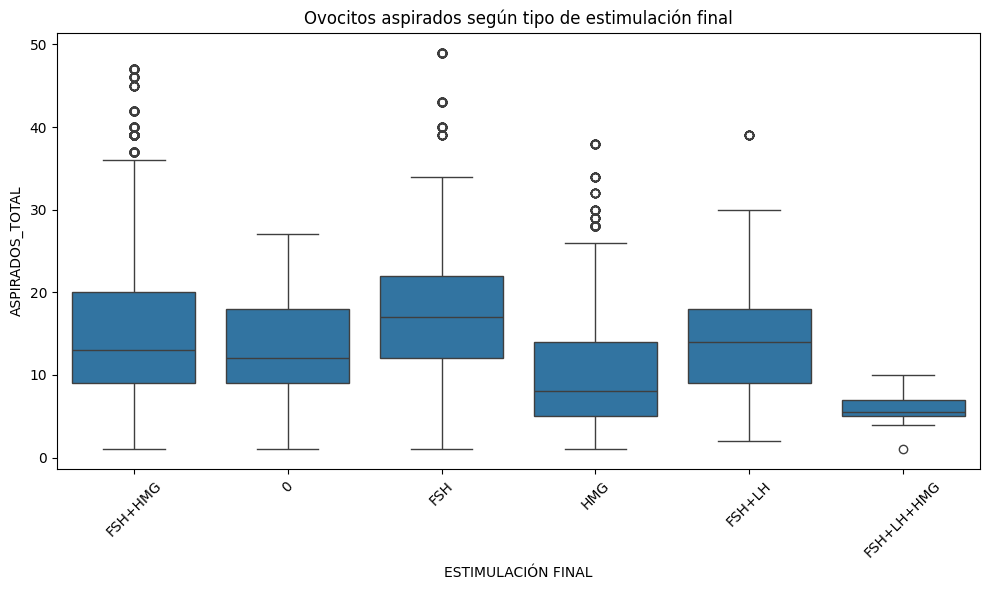

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=data, x='ESTIMULACIÓN FINAL', y='ASPIRADOS_TOTAL')
plt.xticks(rotation=45)
plt.title('Ovocitos aspirados según tipo de estimulación final')
plt.tight_layout()
plt.show()


In [ ]:
data["ESTIMULACIÓN FINAL"].value_counts()

,count
ESTIMULACIÓN FINAL,
FSH+HMG,22013
FSH,3394
HMG,2716
0,1884
FSH+LH,1260
FSH+LH+HMG,36


In [ ]:
grupo_0 = data[data['ESTIMULACIÓN FINAL'] == 0]
grupo_otros = data[data['ESTIMULACIÓN FINAL'] != 0]

print("Media de ovocitos - protocolo 0:", grupo_0['ASPIRADOS_TOTAL'].mean())
print("Media de ovocitos - otros protocolos:", grupo_otros['ASPIRADOS_TOTAL'].mean())


Media de ovocitos - protocolo 0: 13.63089430894309
Media de ovocitos - otros protocolos: 14.900327127337345


In [ ]:
# 1. Filtramos el grupo 0
grupo_0 = data[data['ESTIMULACIÓN FINAL'] == 0]

# 2. Calculamos la matriz de correlación solo para variables numéricas
correlation_matrix = grupo_0.corr(numeric_only=True)

# 3. Seleccionamos la correlación con 'ASPIRADOS_TOTAL' y descartamos la autocorrelación
target_corr = correlation_matrix['ASPIRADOS_TOTAL'].drop(labels=['ASPIRADOS_TOTAL'])

# 4. Ordenamos por fuerza de correlación (en valor absoluto)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# 5. Mostramos las más fuertes (mayor a 0.3 o menor a -0.3)
strong_corr = target_corr_sorted[(target_corr_sorted >= 0.3) | (target_corr_sorted <= -0.3)]

# 6. Imprimimos el resultado
print("Variables con mayor correlación positiva o negativa con ASPIRADOS_TOTAL en el grupo con protocolo 0:\n")
print(strong_corr)


Variables con mayor correlación positiva o negativa con ASPIRADOS_TOTAL en el grupo con protocolo 0:

N_OVO_ASPIRADOS_IN.-_OK            1.000000
OVO_MII_INSEMIN_IN.-_OK            0.940214
OVO_MII_2PN_IN.-_OK                0.809978
Número de blastos intrapaciente    0.728611
OVO_MII_3PN_IN.-_OK                0.725281
EMB_MII_CONGE_IN.-_OK              0.683382
TOTAL EMB (TRF + C)_OK             0.659079
NUM_EMBRIONES_CL_OK                0.638242
INDUCCION1                         0.566382
OvocitoNumero.-                    0.541764
Embryo ID                          0.541764
P4_DHCG_DE.-                       0.491907
ULT_LIN_ENDOM                      0.484096
DONOR BMI                          0.459336
N_Fetuses                         -0.452069
N_FOLIC_ANTRAL_IZQ_IN.-            0.410976
ID_OVOCITO.-_OK                    0.390799
RFA                                0.350568
N_LB                              -0.349881
Well                               0.345664
MAYOR DE 35 AÑOS  

In [ ]:
subset = data[data['ESTIMULACIÓN FINAL'] == '0']
con_ovocitos = subset[subset['N_OVO_ASPIRADOS_IN.-_OK'] > 0]
print(f"{len(con_ovocitos)} de {len(subset)} pacientes obtuvieron ovocitos.")


0 de 0 pacientes obtuvieron ovocitos.


📌 Estadísticas descriptivas del grupo con protocolo 0:

       PATIENT AGE  ANTIUMULLERIANA_DE         RFA  N_FOLIC_ANTRAL_DER_IN.-  \
count   319.000000          319.000000  319.000000               319.000000   
mean     36.043887           14.934357   12.442006                 6.335423   
std       2.748004            7.079948    4.535907                 2.539691   
min      30.000000            5.610000    4.000000                 2.000000   
25%      34.000000            9.285000    9.000000                 4.000000   
50%      36.000000           13.750000   12.000000                 6.000000   
75%      38.000000           18.020000   14.000000                 7.000000   
max      41.000000           63.220000   27.000000                15.000000   

       N_FOLIC_ANTRAL_IZQ_IN.-  PATIENT BMI  ASPIRADOS_TOTAL  
count               319.000000   319.000000       319.000000  
mean                  6.106583    23.353636        12.934169  
std                   2.587085     2.883235

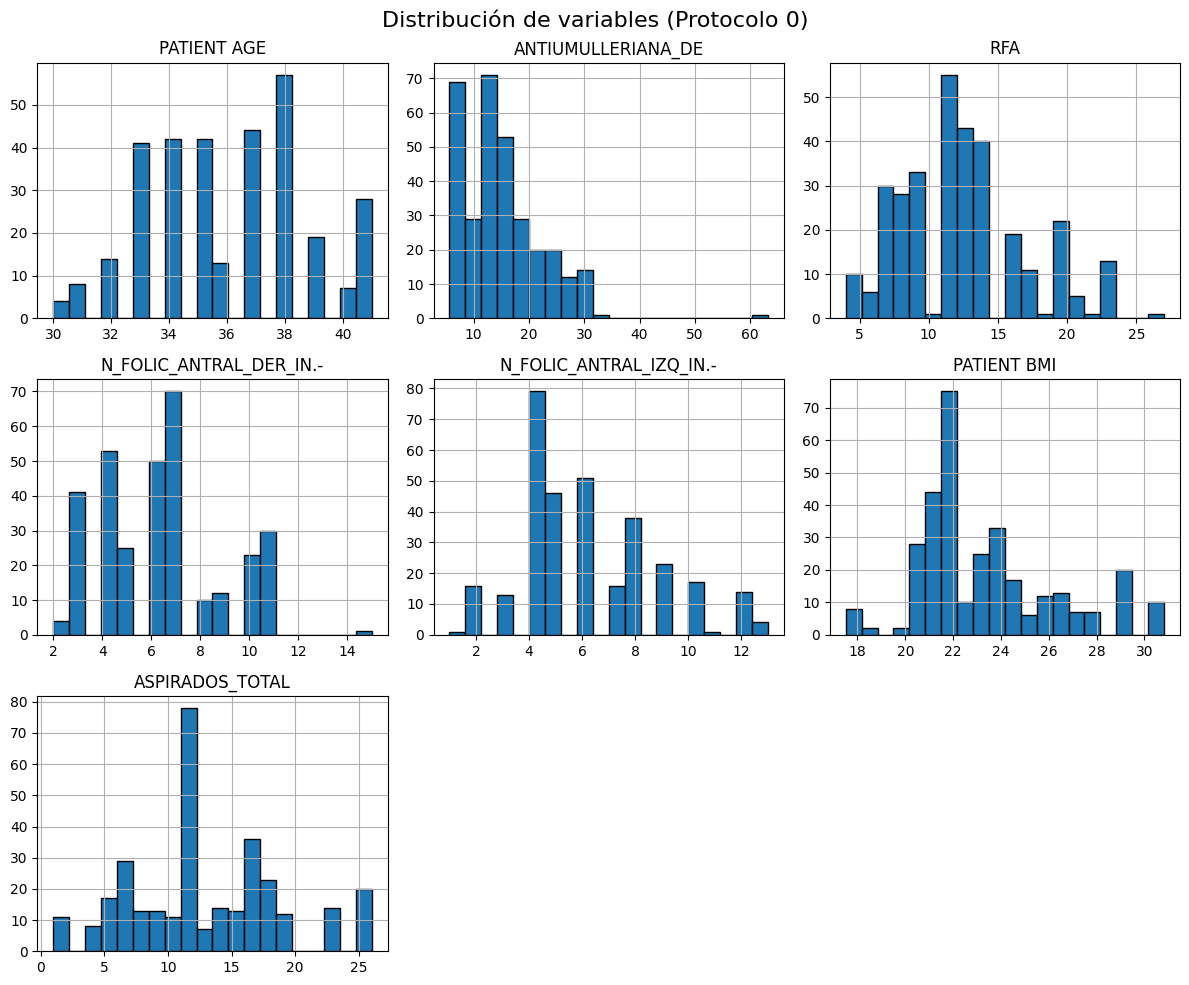

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtrar grupo 0
grupo_0 = data[data['ESTIMULACIÓN FINAL'] == 0]

# 2. Seleccionar variables clínicas relevantes
vars_interes = [
    'PATIENT AGE',
    'ANTIUMULLERIANA_DE',
    'RFA',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'PATIENT BMI',
    'ASPIRADOS_TOTAL'
]

grupo_0 = grupo_0[vars_interes].dropna()

# 3. Estadísticas descriptivas
print("📌 Estadísticas descriptivas del grupo con protocolo 0:\n")
print(grupo_0.describe())

# 4. Histograma para cada variable
grupo_0.hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distribución de variables (Protocolo 0)", fontsize=16)
plt.tight_layout()
plt.show()




In [ ]:
#SOLO NOS NTERESAN LOS 4 ESTIMULOS, ELIMINAMOS POR UNN LADO EL 0 Y EL ESTIMULO QUE ENGLOBA TODO
# Lista de los 4 protocolos que SÍ quieres analizar
protocolos_validos = ['FSH', 'FSH+HMG', 'HMG', 'FSH+LH']

# Filtrar solo esos protocolos
data_filtrada = data[data['ESTIMULACIÓN FINAL'].isin(protocolos_validos)]
data_filtrada['ESTIMULACIÓN FINAL'].value_counts()

,count
ESTIMULACIÓN FINAL,
FSH+HMG,22013
FSH,3394
HMG,2716
FSH+LH,1260


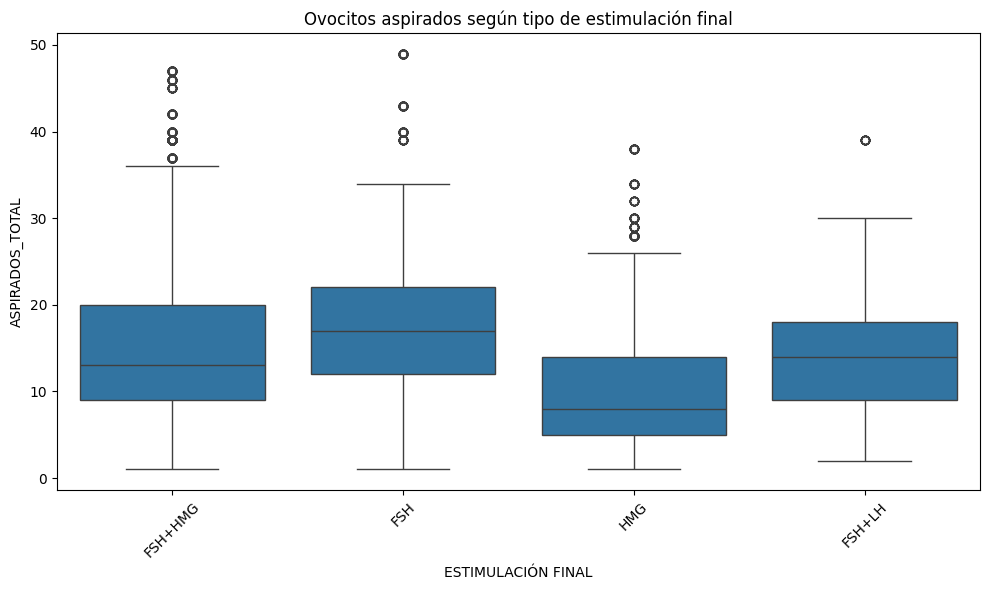

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=data_filtrada, x='ESTIMULACIÓN FINAL', y='ASPIRADOS_TOTAL')
plt.xticks(rotation=45)
plt.title('Ovocitos aspirados según tipo de estimulación final')
plt.tight_layout()
plt.show()

Este gráfico muestra cómo varía la cantidad de ovocitos aspirados en función del protocolo de estimulación hormonal utilizado. Cada caja representa un grupo de pacientes que recibió el mismo tipo de tratamiento, y resume cómo fueron los resultados dentro de ese grupo.

-FSH+HMG. De losprotocolos con mejor respuesta ovaríca
  *   La mediana (línea dentro de la caja) está alta, en torno a 14–15  
      ovocitos.
  *   La mayoría de pacientes con este protocolo obtuvo entre 10 y 20   
      ovocitos, un rango que consideramos una buena respuesta.
  *   Hay varios outliers por encima, lo que significa que algunas
      pacientes consiguieron incluso más de 30–35 ovocitos, siendo hiperrespondedoras.

-FSH.
  * El protocolo FSH muestra una muy buena respuesta ovárica, con la mediana más alta de todos los grupos, lo que indica que la mitad de las pacientes obtuvo más ovocitos en comparación con los demás protocolos.Sin embargo, su rango intercuartílico (la caja) es más pequeño, lo que significa que la mayoría de las pacientes tuvo resultados más similares entre sí, con menor variabilidad.En cambio, FSH+HMG tiene una mediana un poco más baja, pero muestra una mayor dispersión en las respuestas y más outliers altos, lo que sugiere que algunas pacientes pueden tener una respuesta mucho más intensa, aunque el grupo en general sea más variable

-HMG

  *  En este protocolo observamos que, aunque los resultados no son malos, sí son más limitados en comparación con otros tipos de estimulación.La mediana es más baja, lo que indica que la mitad de las pacientes obtuvo una cantidad de ovocitos inferior respecto a protocolos como FSH o FSH+HMG.La caja del boxplot es más estrecha, lo que sugiere que las pacientes responden de forma más homogénea, es decir, no hay grandes diferencias entre unas y otras.La mayoría de las pacientes obtuvieron entre 5 y 25 ovocitos, lo que indica una respuesta moderada pero estable.Además, se observan algunos outliers altos, aunque en menor número que otros protocolos, lo que refuerza la idea de una respuesta más controlada y menos extrema.Este tipo de protocolo puede utilizarse en pacientes con características clínicas específicas, donde se busca una estimulación más suave o con menor variabilidad.


-FSH+LH

  *   Este protocolo muestra una respuesta moderadamente buena, con una mediana relativamente alta, lo que indica que la mitad de las pacientes obtuvo una cantidad adecuada de ovocitos.La caja del boxplot tiene un tamaño intermedio, lo cual sugiere una variedad razonable de respuestas, sin ser tan disperso como FSH+HMG pero tampoco tan homogéneo como HMG.La mayoría de las pacientes obtuvo entre 8 y 25 ovocitos, lo que refleja una respuesta ovárica bastante equilibrada.Se observan algunos outliers altos, lo cual indica que hay pacientes que respondieron muy bien a esta combinación hormonal.En resumen, FSH+LH parece ser un protocolo con resultados consistentes y efectivos, que podría ser útil para pacientes con perfil intermedio o que necesitan un pequeño refuerzo de LH para mejorar su respuesta.

FSH+LH+HMG

  *   ste protocolo presenta la respuesta más baja de todos los grupos analizados.La mediana es visiblemente inferior, y la caja es muy pequeña, lo que indica que la mayoría de las pacientes tuvo una respuesta baja y bastante similar entre sí.La mayoría se sitúa entre 4 y 8 ovocitos aspirados, lo que sugiere un uso más frecuente en pacientes con baja reserva ovárica o antecedentes de baja respuesta.Prácticamente no hay outliers altos, lo que confirma que este protocolo no genera respuestas muy elevadas, sino que parece estar diseñado para pacientes donde se busca una estimulación suave o adaptada a una baja capacidad ovárica.En resumen, FSH+LH+HMG es un protocolo probablemente usado en casos clínicos más delicados, y aunque no consigue altas cifras de ovocitos, puede ser adecuado para pacientes con ciertas limitaciones.

CONCLUSION:

  Comparando los protocolos FSH y FSH+HMG, se observa que ambos muestran una respuesta ovárica sólida, con medianas altas y rangos de ovocitos bastante amplios.Si bien el protocolo FSH+HMG muestra una mayor variabilidad y más casos con respuestas extremas (outliers altos), la diferencia en la mediana con respecto a FSH no es sustancialmente grande.Esto sugiere que añadir HMG al protocolo basado en FSH puede ofrecer una ligera ventaja, especialmente en pacientes que podrían beneficiarse de una estimulación más intensa, pero no necesariamente garantiza una mejora significativa para todos los perfiles.Por tanto, ambos protocolos podrían considerarse eficaces, y la elección puede depender más del contexto clínico específico de la paciente que de diferencias marcadas en los resultados medios








In [ ]:
# Seleccionamos solo las columnas necesarias para el modelo
cols = [
    "ESTIMULACIÓN FINAL",
    "PATIENT AGE",
    "PATIENT BMI",
    "Dosis alta (>2500)",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()


In [ ]:
#ONE HOT ENCODEING
df_dummies=pd.get_dummies(df_model, columns=['ESTIMULACIÓN FINAL'])

Aquí seleccionamos las variables clínicas que, según la literatura, afectan la respuesta ovárica y, por tanto, la cantidad de ovocitos aspirados.

In [ ]:
df_dummies.head(5)

,PATIENT AGE,PATIENT BMI,Dosis alta (>2500),ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ASPIRADOS_TOTAL,ESTIMULACIÓN FINAL_FSH,ESTIMULACIÓN FINAL_FSH+HMG,ESTIMULACIÓN FINAL_FSH+LH,ESTIMULACIÓN FINAL_HMG
0,35,24.13,NaN,NaN,NaN,NaN,4100.0,NaN,13.0,False,True,False,False
1,35,24.13,NaN,NaN,NaN,NaN,4100.0,NaN,13.0,False,True,False,False
2,35,24.13,NaN,NaN,NaN,NaN,4100.0,NaN,13.0,False,True,False,False
3,35,24.13,NaN,NaN,NaN,NaN,4100.0,NaN,13.0,False,True,False,False
4,35,24.13,NaN,NaN,NaN,NaN,4100.0,NaN,13.0,False,True,False,False


                         PATIENT AGE  PATIENT BMI  Dosis alta (>2500)  \
PATIENT AGE                 1.000000     0.006715            0.009976   
PATIENT BMI                 0.006715     1.000000            0.098058   
Dosis alta (>2500)          0.009976     0.098058            1.000000   
ANTIUMULLERIANA_DE         -0.233677    -0.023325            0.326389   
N_FOLIC_ANTRAL_DER_IN.-    -0.268548     0.025470            0.257521   
N_FOLIC_ANTRAL_IZQ_IN.-    -0.285623     0.023229            0.157628   
DOSIS TOTAL                 0.262633     0.099921            0.855875   
RFA                        -0.290488     0.027556            0.236714   
ASPIRADOS_TOTAL            -0.254840    -0.012652            0.376561   

                         ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
PATIENT AGE                       -0.233677                -0.268548   
PATIENT BMI                       -0.023325                 0.025470   
Dosis alta (>2500)                 0.326389          

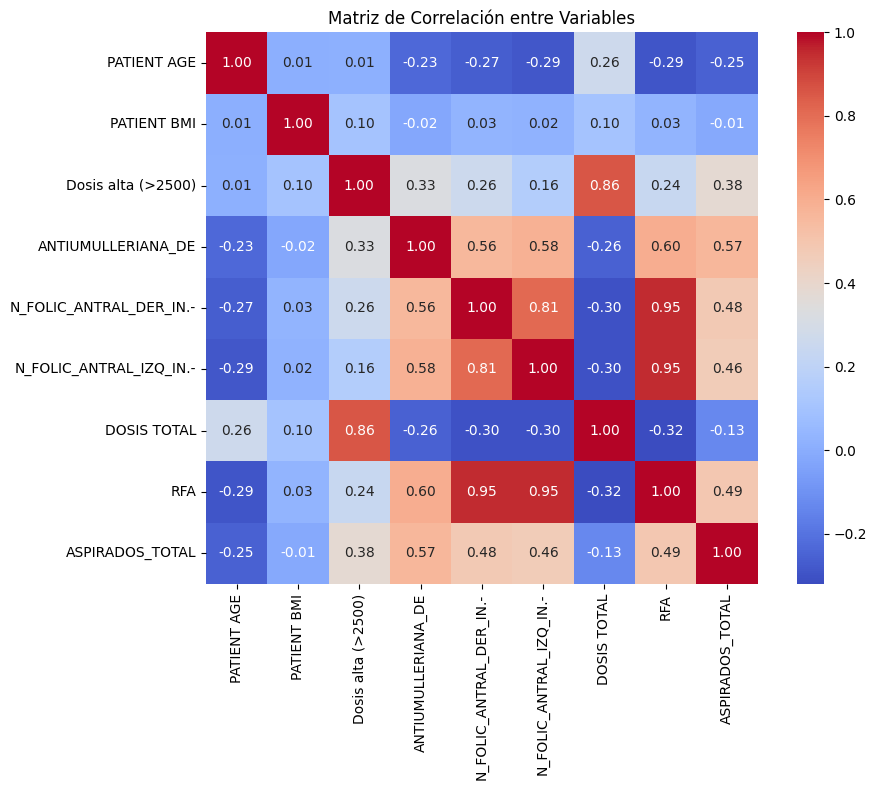

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calcular la matriz de correlación (solo variables numéricas)
correlation_matrix = df_model.corr(numeric_only=True)
print(correlation_matrix)
# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()

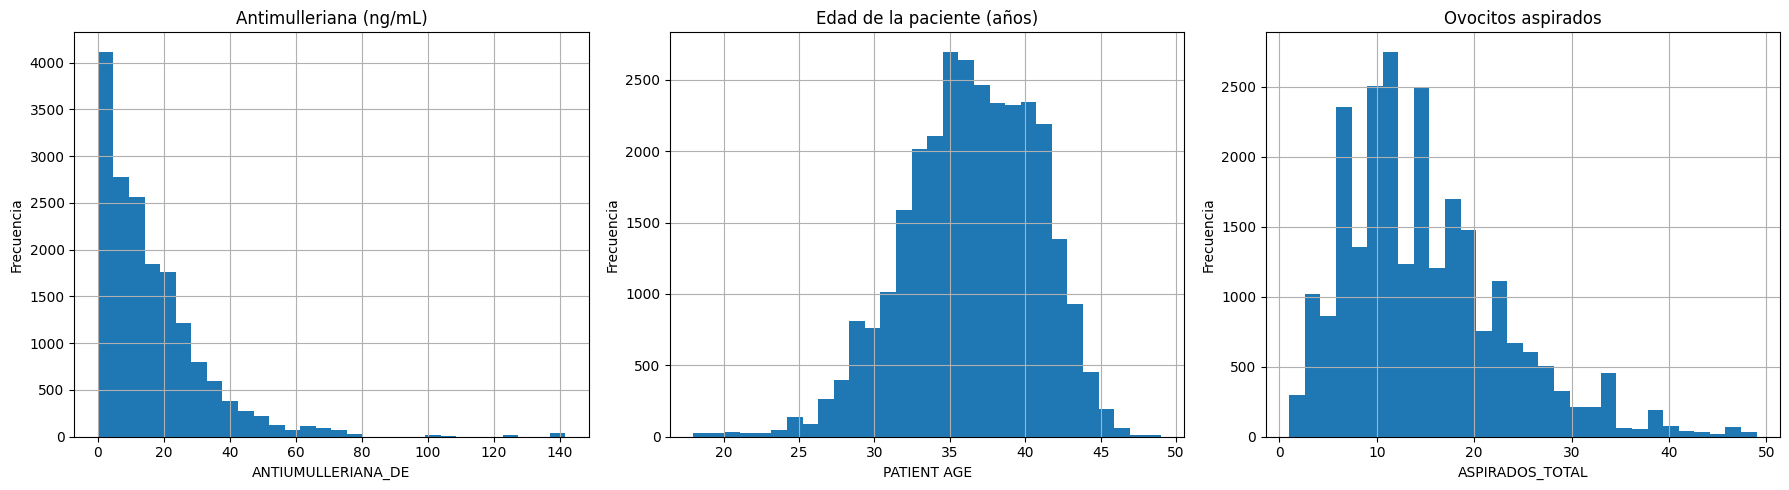

In [ ]:
# Crear histogramas de las 3 variables solicitadas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variables a graficar
variables = ['ANTIUMULLERIANA_DE', 'PATIENT AGE', 'ASPIRADOS_TOTAL']
titulos = ['Antimulleriana (ng/mL)', 'Edad de la paciente (años)', 'Ovocitos aspirados']

# Crear cada histograma
for ax, var, titulo in zip(axes, variables, titulos):
    df_model[var].dropna().hist(ax=ax, bins=30)
    ax.set_title(titulo)
    ax.set_xlabel(var)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


#
 📊 Exploración inicial de variables clave

Se analizan tres variables importantes en el contexto del modelo:
- ANTIUMULLERIANA_DE: marcador de reserva ovárica.
- PATIENT AGE: edad de la paciente.
- ASPIRADOS_TOTAL: número de ovocitos obtenidos tras punción.

 El objetivo es entender la distribución de estas variables para:
 1. Identificar posibles sesgos o asimetrías.
 2. Evaluar la necesidad de transformaciones (e.g., logarítmica).
 3. Visualizar rangos frecuentes y posibles valores atípicos.

 🔍 Resultados de los histogramas:

 ✔️ Antimulleriana presenta una distribución asimétrica a la derecha, con alta frecuencia de valores bajos
 y unos pocos valores muy altos. Esto sugiere una posible transformación logarítmica si se aplica regresión lineal.

 ✔️ La edad de las pacientes se distribuye de forma más simétrica, centrada alrededor de los 35 años,lo que refleja el perfil típico de pacientes en tratamientos de fertilidad.

✔️ El número de ovocitos aspirados (ASPIRADOS_TOTAL) también es asimétrico, concentrado en torno a 10–15,pero con una cola hacia valores más altos (hasta 40–50). Esta variable será nuestra variable objetivo (y) principal.

Estos análisis permiten seleccionar adecuadamente los métodos de modelado y decidir si se requieren ajustes
en las variables antes de entrenar los modelos.


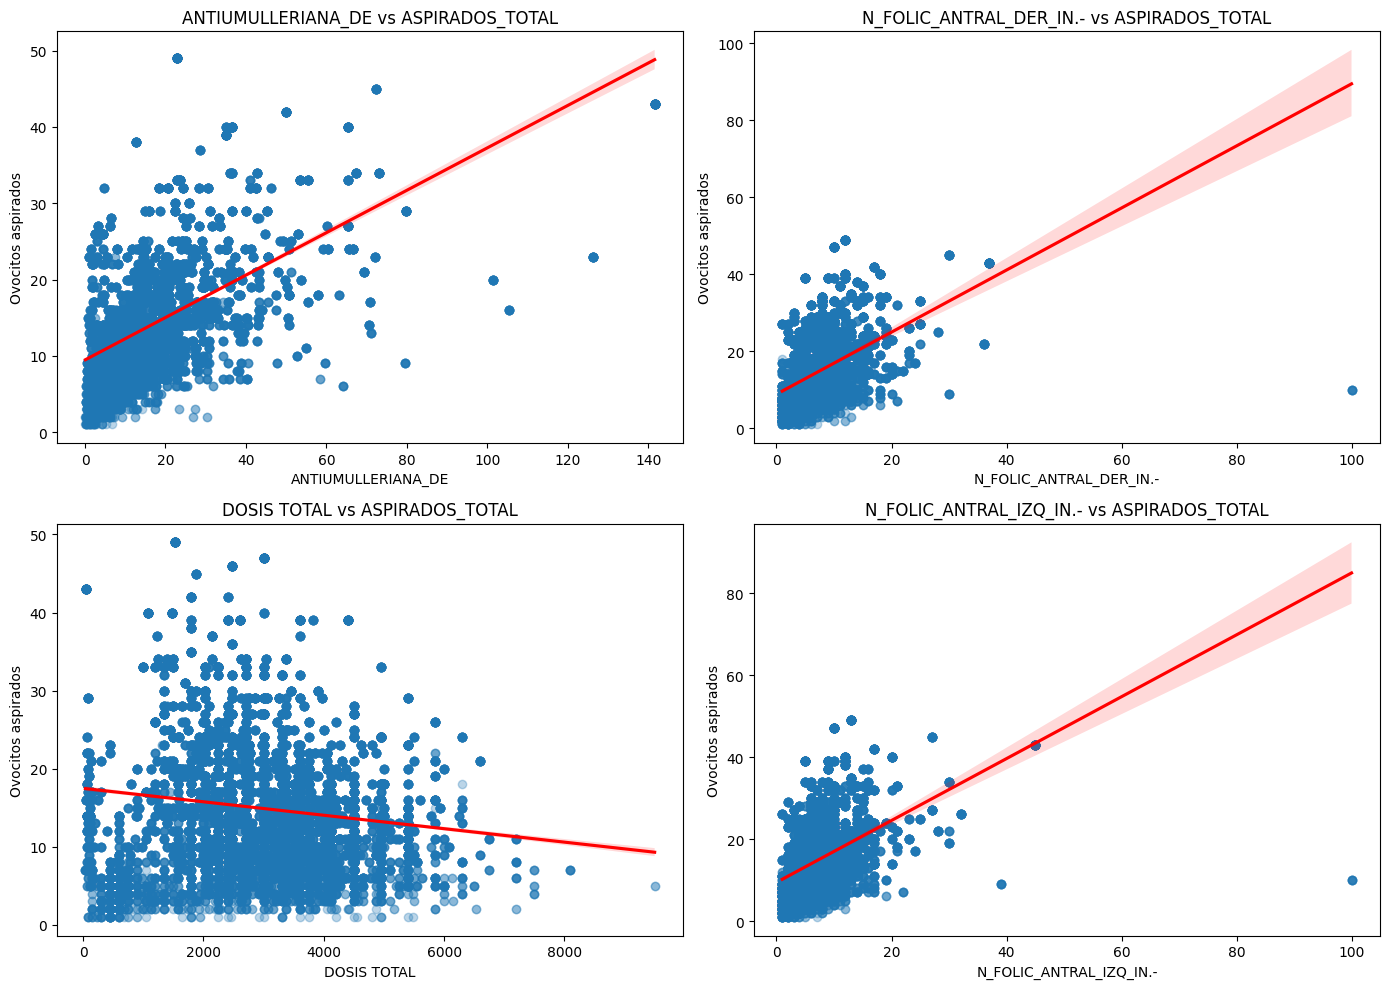

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables que queremos analizar frente a ASPIRADOS_TOTAL
predictoras = ['ANTIUMULLERIANA_DE', 'N_FOLIC_ANTRAL_DER_IN.-', 'DOSIS TOTAL', 'N_FOLIC_ANTRAL_IZQ_IN.-','Dosis alta (>2500)','PATIENT AGE','ESTIMULACIÓN FINAL_FSH']
objetivo = 'ASPIRADOS_TOTAL'

# Crear los scatter plots con línea de regresión
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, var in zip(axes.flat, predictoras):
    sns.regplot(data=df_model, x=var, y=objetivo, ax=ax, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
    ax.set_title(f'{var} vs {objetivo}')
    ax.set_xlabel(var)
    ax.set_ylabel('Ovocitos aspirados')

plt.tight_layout()
plt.show()


In [ ]:
#¿QUE HACER CON LOS NULOS?
df_model.info()
df_model.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 29383 entries, 0 to 31299
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ESTIMULACIÓN FINAL       29383 non-null  object 
 1   PATIENT AGE              29383 non-null  int64  
 2   PATIENT BMI              27751 non-null  float64
 3   Dosis alta (>2500)       460 non-null    float64
 4   ANTIUMULLERIANA_DE       17145 non-null  float64
 5   N_FOLIC_ANTRAL_DER_IN.-  20581 non-null  float64
 6   N_FOLIC_ANTRAL_IZQ_IN.-  20517 non-null  float64
 7   DOSIS TOTAL              29383 non-null  float64
 8   RFA                      20313 non-null  float64
 9   ASPIRADOS_TOTAL          24729 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5+ MB


,0
ESTIMULACIÓN FINAL,0
PATIENT AGE,0
PATIENT BMI,1632
Dosis alta (>2500),28923
ANTIUMULLERIANA_DE,12238
N_FOLIC_ANTRAL_DER_IN.-,8802
N_FOLIC_ANTRAL_IZQ_IN.-,8866
DOSIS TOTAL,0
RFA,9070
ASPIRADOS_TOTAL,4654


In [ ]:
df_model['Dosis_alta_reconstruida'] = (df_model['DOSIS TOTAL'] > 2500).astype(int)


In [ ]:
#Ligera correlacion pero puede ser valiosa
df_model[['Dosis_alta_reconstruida', 'ASPIRADOS_TOTAL']].corr()


,Dosis_alta_reconstruida,ASPIRADOS_TOTAL
Dosis_alta_reconstruida,1.000000,-0.159651
ASPIRADOS_TOTAL,-0.159651,1.000000


In [ ]:
# Eliminar filas sin variable objetivo (importante)
df_model = df_model.dropna(subset=['ASPIRADOS_TOTAL'])

# Rellenar con la mediana las variables importantes
cols_rellenar = [
    'PATIENT BMI',
    'ANTIUMULLERIANA_DE',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'DOSIS TOTAL',
    'RFA'
]

df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())


<ipython-input-20-6c16949d518d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())


In [ ]:
df_model=df_model.drop(columns=['Dosis alta (>2500)'])

In [ ]:
df_model.info()
df_model.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 24729 entries, 0 to 26796
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ESTIMULACIÓN FINAL       24729 non-null  object 
 1   PATIENT AGE              24729 non-null  int64  
 2   PATIENT BMI              24729 non-null  float64
 3   ANTIUMULLERIANA_DE       24729 non-null  float64
 4   N_FOLIC_ANTRAL_DER_IN.-  24729 non-null  float64
 5   N_FOLIC_ANTRAL_IZQ_IN.-  24729 non-null  float64
 6   DOSIS TOTAL              24729 non-null  float64
 7   RFA                      24729 non-null  float64
 8   ASPIRADOS_TOTAL          24729 non-null  float64
 9   Dosis_alta_reconstruida  24729 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 2.1+ MB


,0
ESTIMULACIÓN FINAL,0
PATIENT AGE,0
PATIENT BMI,0
ANTIUMULLERIANA_DE,0
N_FOLIC_ANTRAL_DER_IN.-,0
N_FOLIC_ANTRAL_IZQ_IN.-,0
DOSIS TOTAL,0
RFA,0
ASPIRADOS_TOTAL,0
Dosis_alta_reconstruida,0


In [ ]:
df_model.head(5)

,ESTIMULACIÓN FINAL,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ASPIRADOS_TOTAL,Dosis_alta_reconstruida
0,FSH+HMG,35,24.13,14.52,7.0,6.0,4100.0,13.0,13.0,1
1,FSH+HMG,35,24.13,14.52,7.0,6.0,4100.0,13.0,13.0,1
2,FSH+HMG,35,24.13,14.52,7.0,6.0,4100.0,13.0,13.0,1
3,FSH+HMG,35,24.13,14.52,7.0,6.0,4100.0,13.0,13.0,1
4,FSH+HMG,35,24.13,14.52,7.0,6.0,4100.0,13.0,13.0,1


In [ ]:
df_model=pd.get_dummies(df_model, columns=['ESTIMULACIÓN FINAL'])

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df_model.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model["ASPIRADOS_TOTAL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Lista de modelos a comparar
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Red Neuronal (MLP)": MLPRegressor(random_state=42, max_iter=500)
}

# 3. Evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{nombre}:\n  MAE = {mae:.2f}\n  RMSE = {rmse:.2f}\n  R² = {r2:.2f}\n")


Regresión Lineal:
  MAE = 5.30
  RMSE = 6.92
  R² = 0.29

Random Forest:
  MAE = 0.20
  RMSE = 0.82
  R² = 0.99

Gradient Boosting:
  MAE = 4.51
  RMSE = 5.86
  R² = 0.49

Red Neuronal (MLP):
  MAE = 4.15
  RMSE = 5.42
  R² = 0.56



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Como ya sabemos estas son las metricas que tenemos que tener en cuenta para elegir un modelo de predicción:

  * MAE(mean absolut Error):Diferncia entre el valor real y los predichos.
  cuanto  menor sea mejor.
  * RMSE(Raíz del Error Cuadrático Medio):Similar al MAE, pero penaliza más los errores grandes.
  * R2:Mide qué porcentaje de la variabilidad del objetivo (ASPIRADOS_TOTAL) explica el modelo.Va de 0 (explica nada) a 1 (explica todo).
  
Por ende el mejor resultado es el Random Forest


In [ ]:
#Revisamos que no hay overfifting ya que el R2 es muy bueno
y_train_pred = modelo.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"R² en entrenamiento: {r2_train:.2f}")


R² en entrenamiento: 0.59


In [ ]:
#Vemos que es mas bajo, raro porque deberia ser al reves no tan bueno en el test u mejor en el train.Posible causa division de los datos favorable
#Por eso validacion criuzada
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

modelo = RandomForestRegressor(random_state=42)
scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring='r2')

print("R² por fold:", scores)
print("R² medio (validación cruzada):", np.mean(scores))


R² por fold: [0.1355467  0.11366633 0.11747039 0.21243317 0.04589796]
R² medio (validación cruzada): 0.12500290970867806


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,             # limitar profundidad
    min_samples_leaf=10,     # evitar ramas pequeñas
    random_state=42
)

scores = cross_val_score(modelo_rf, X_scaled, y, cv=5, scoring='r2')
print("R² por fold:", scores)
print("R² medio:", np.mean(scores))


R² por fold: [0.26021992 0.20652076 0.26894023 0.37920782 0.22924881]
R² medio: 0.2688275074491246


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

modelo_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

scores_gb = cross_val_score(modelo_gb, X_scaled, y, cv=5, scoring='r2')
print("R² por fold (GB):", scores_gb)
print("R² medio (GB):", np.mean(scores_gb))


R² por fold (GB): [0.20170077 0.15804469 0.25700127 0.33842911 0.1982477 ]
R² medio (GB): 0.23068470837469865


Puede ser que haya mucho ruido vamos a ver


                            PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  \
PATIENT AGE                    1.000000     0.017210           -0.216832   
PATIENT BMI                    0.017210     1.000000            0.011573   
ANTIUMULLERIANA_DE            -0.216832     0.011573            1.000000   
N_FOLIC_ANTRAL_DER_IN.-       -0.227567     0.029953            0.469669   
N_FOLIC_ANTRAL_IZQ_IN.-       -0.238342     0.022382            0.478716   
DOSIS TOTAL                    0.257313     0.096294           -0.238443   
RFA                           -0.241821     0.029064            0.497496   
ASPIRADOS_TOTAL               -0.254840    -0.011711            0.408646   
Dosis_alta_reconstruida        0.269824     0.098811           -0.230109   
ESTIMULACIÓN FINAL_FSH        -0.323571    -0.025179            0.269963   
ESTIMULACIÓN FINAL_FSH+HMG     0.147408     0.038452           -0.108507   
ESTIMULACIÓN FINAL_FSH+LH      0.042492    -0.011334           -0.040730   
ESTIMULACIÓN

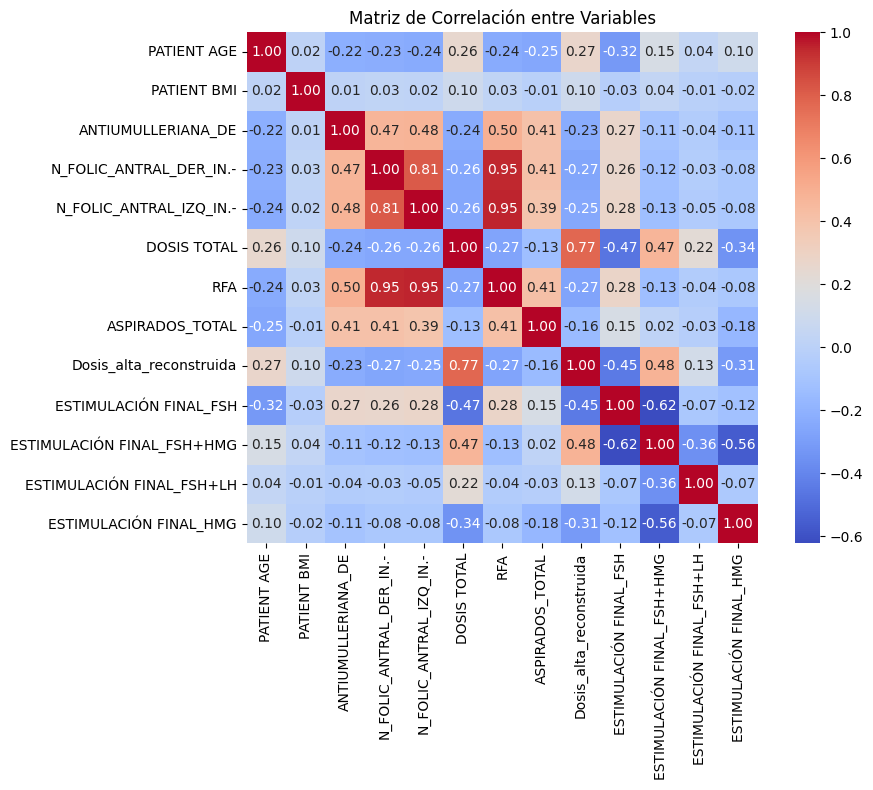

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calcular la matriz de correlación (solo variables numéricas)
correlation_matrix = df_model.corr(numeric_only=True)
print(correlation_matrix)
# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()

In [ ]:
# Tras entrenar tu modelo
modelo.fit(X_train, y_train)

# Importancia de cada variable
importancias = modelo.feature_importances_
for nombre, importancia in zip(X.columns, importancias):
    print(f"{nombre}: {importancia:.3f}")


PATIENT AGE: 0.136
PATIENT BMI: 0.191
ANTIUMULLERIANA_DE: 0.193
N_FOLIC_ANTRAL_DER_IN.-: 0.040
N_FOLIC_ANTRAL_IZQ_IN.-: 0.035
DOSIS TOTAL: 0.141
RFA: 0.232
Dosis_alta_reconstruida: 0.006
ESTIMULACIÓN FINAL_FSH: 0.005
ESTIMULACIÓN FINAL_FSH+HMG: 0.008
ESTIMULACIÓN FINAL_FSH+LH: 0.003
ESTIMULACIÓN FINAL_HMG: 0.010


In [ ]:
#pUEDE QUE ONE-HOT NO NOS ESTE AYUDANDO
# Codificamos la columna como categoría numérica
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_filtrada['ESTIMULACIÓN FINAL COD'] = le.fit_transform(data_filtrada['ESTIMULACIÓN FINAL'])

# Luego actualizas tu df_model incluyendo esta nueva columna
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACIÓN FINAL COD",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()




<ipython-input-8-ed2e02e600b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtrada['ESTIMULACIÓN FINAL COD'] = le.fit_transform(data_filtrada['ESTIMULACIÓN FINAL'])


In [ ]:
# Eliminar filas sin variable objetivo (importante)
df_model = df_model.dropna(subset=['ASPIRADOS_TOTAL'])

# Rellenar con la mediana las variables importantes
cols_rellenar = [
    'PATIENT BMI',
    'ANTIUMULLERIANA_DE',
    'N_FOLIC_ANTRAL_DER_IN.-',
    'N_FOLIC_ANTRAL_IZQ_IN.-',
    'DOSIS TOTAL',
    'RFA'
]

df_model[cols_rellenar] = df_model[cols_rellenar].fillna(df_model[cols_rellenar].median())

In [ ]:
df_model.head(5)

,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ESTIMULACIÓN FINAL COD,ASPIRADOS_TOTAL
0,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,13.0
1,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,13.0
2,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,13.0
3,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,13.0
4,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,13.0


In [ ]:
from sklearn.preprocessing import StandardScaler

X = df_model.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model["ASPIRADOS_TOTAL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Revisamos que no hay overfifting ya que el R2 es muy bueno
y_train_pred = modelo.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"R² en entrenamiento: {r2_train:.2f}")

R² en entrenamiento: 1.00


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Crear el modelo
modelo = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Evaluación con validación cruzada (5-fold)
scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring='r2')

# Mostrar los resultados
print("R² por fold:", scores)
print("R² medio (validación cruzada):", np.mean(scores))



R² por fold: [0.19353881 0.17230454 0.25178234 0.32683294 0.1918594 ]
R² medio (validación cruzada): 0.2272636074395426


In [ ]:
"""
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACIÓN FINAL COD",
    "dias_estim_e_cl.-",
    "P4_DHCG_DE.-",
    "NIVEL_FSH_H_DE.-_OK",
    "ULT_LIN_ENDOM",
    "ampollas_fsh_e_cl.-",
    "ampollas_lh_e_cl.-",
    "ASPIRADOS_TOTAL"
]

df_model = data_filtrada[cols].copy()

# Limpieza rápida
df_model1= df_model.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target
df_model1 = df_model1.fillna(df_model.median(numeric_only=True))  # imputar predictoras
"""

'\ncols = [\n    "PATIENT AGE",\n    "PATIENT BMI",\n    "ANTIUMULLERIANA_DE",\n    "N_FOLIC_ANTRAL_DER_IN.-",\n    "N_FOLIC_ANTRAL_IZQ_IN.-",\n    "DOSIS TOTAL",\n    "RFA",\n    "ESTIMULACIÓN FINAL COD",\n    "dias_estim_e_cl.-",\n    "P4_DHCG_DE.-",\n    "NIVEL_FSH_H_DE.-_OK",\n    "ULT_LIN_ENDOM",\n    "ampollas_fsh_e_cl.-",\n    "ampollas_lh_e_cl.-",\n    "ASPIRADOS_TOTAL"\n]\n\ndf_model = data_filtrada[cols].copy()\n\n# Limpieza rápida\ndf_model1= df_model.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target\ndf_model1 = df_model1.fillna(df_model.median(numeric_only=True))  # imputar predictoras\n'

In [ ]:
#df_model1.head(20)

In [ ]:
cols = [
    "PATIENT AGE",
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-",
    "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL",
    "RFA",
    "ESTIMULACIÓN FINAL COD",
    "dias_estim_e_cl.-",
    "P4_DHCG_DE.-",
    "NIVEL_FSH_H_DE.-_OK",
    "ULT_LIN_ENDOM",
    "ampollas_fsh_e_cl.-",
    "ampollas_lh_e_cl.-",
    "ASPIRADOS_TOTAL"
]

df_model_agrupacion = data_filtrada[cols].copy()



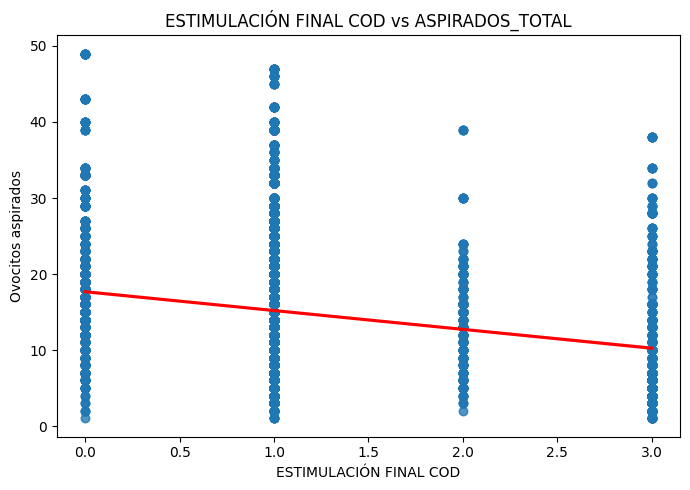

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

predictoras = ['ESTIMULACIÓN FINAL COD']
objetivo = 'ASPIRADOS_TOTAL'

# Como solo hay una variable, se puede crear una única figura directamente
plt.figure(figsize=(7, 5))
sns.regplot(data=df_model, x=predictoras[0], y=objetivo,
            scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title(f'{predictoras[0]} vs {objetivo}')
plt.xlabel(predictoras[0])
plt.ylabel('Ovocitos aspirados')
plt.tight_layout()
plt.show()


In [ ]:
df_model_agrupacion= df_model_agrupacion.dropna(subset=["ASPIRADOS_TOTAL"])  # nunca imputar el target
df_model_agrupacion = df_model_agrupacion.fillna(df_model.median(numeric_only=True))  # imputar predictoras

In [ ]:
"""def clasificar_ovocitos(n):
    if n < 6:
        return "Bajo"
    elif n <= 15:
        return "Medio"
    else:
        return "Alto"

df_model_agrupacion["ASPIRADOS_GRUPO"] = df_model_agrupacion["ASPIRADOS_TOTAL"].apply(clasificar_ovocitos)
"""

'def clasificar_ovocitos(n):\n    if n < 6:\n        return "Bajo"\n    elif n <= 15:\n        return "Medio"\n    else:\n        return "Alto"\n\ndf_model_agrupacion["ASPIRADOS_GRUPO"] = df_model_agrupacion["ASPIRADOS_TOTAL"].apply(clasificar_ovocitos)\n'

urante el ajuste del modelo de clasificación, se configuraron varios hiperparámetros del RandomForestClassifier con el objetivo de mejorar su capacidad predictiva y evitar el sobreajuste. A continuación se describen los principales:

n_estimators: número de árboles en el bosque. Un mayor número de árboles suele mejorar la estabilidad y precisión del modelo. Se usó un valor de 300 para obtener mayor robustez sin comprometer el tiempo de cómputo.

max_depth: profundidad máxima de cada árbol. Este parámetro controla la complejidad del modelo. Se limitó a 8 niveles para evitar sobreajuste y mantener interpretabilidad.

min_samples_split: número mínimo de muestras necesarias para dividir un nodo. Se fijó en 10, lo que obliga al modelo a generar ramas más generales y evita divisiones sobre grupos muy pequeños.

min_samples_leaf: número mínimo de muestras en una hoja (nodo final). Se estableció en 5 para prevenir ramas que representen únicamente casos individuales.

max_features: número de variables que se consideran al dividir cada nodo. Se utilizó "sqrt", que es el valor recomendado para clasificación y ayuda a reducir la varianza.

class_weight: se estableció como "balanced" para corregir el desbalance natural entre clases ("Bajo", "Medio" y "Alto") en el conjunto de datos. Esto fuerza al modelo a prestar más atención a las clases menos representadas.

In [ ]:
#df_model_agrupacion["ASPIRADOS_GRUPO"].value_counts(normalize=True)

In [ ]:
"""
uts = pd.qcut(df_model_agrupacion["ASPIRADOS_TOTAL"], q=3, retbins=True)[1]
print(cuts)
"""

'\nuts = pd.qcut(df_model_agrupacion["ASPIRADOS_TOTAL"], q=3, retbins=True)[1]\nprint(cuts)\n'

Como podemos ver los rangos on
    -Bajo 1 a 10
    -Medio 10 a 17
    -Alto 17 a 40

In [ ]:
df_model_agrupacion.head(10)

,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ESTIMULACIÓN FINAL COD,dias_estim_e_cl.-,P4_DHCG_DE.-,NIVEL_FSH_H_DE.-_OK,ULT_LIN_ENDOM,ampollas_fsh_e_cl.-,ampollas_lh_e_cl.-,ASPIRADOS_TOTAL
0,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
1,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
2,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
3,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
4,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
5,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
6,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
7,35,24.13,14.52,7.0,6.0,4100.0,13.0,1,15.0,1.40,0.0,6.0,2700.0,NaN,13.0
8,36,25.39,14.52,7.0,6.0,4875.0,13.0,1,14.0,NaN,0.0,13.7,3900.0,NaN,2.0
9,30,19.92,14.52,8.0,8.0,1575.0,16.0,1,10.0,1.85,0.0,5.0,900.0,NaN,17.0


In [ ]:
X_OVOCTIOS = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y_class = df_model_agrupacion["ASPIRADOS_TOTAL"]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_OVOCITOS = scaler.fit_transform(X_OVOCTIOS)


In [ ]:
#Aplicar grid search para saber que parametros hay que usar
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
rf=RandomForestClassifier(random_state=42)
param_dist={

    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(5, 20),
    'min_samples_leaf': randint(2, 10),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']

}
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,  # nº de combinaciones a probar
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1  # usa todos los núcleos
)

# Entrenamos la búsqueda
random_search.fit(X_scaled_OVOCITOS, y_class)

# Mostramos los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Y la mejor accuracy obtenida
print(f"Mejor accuracy obtenido: {random_search.best_score_:.2f}")


KeyboardInterrupt: 

PROBAMOS OTRO MODELO CON LA INTENCION DE MEJORAR LA ACCURACY

In [ ]:
pip install catboost


In [ ]:
"""
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Selección de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_GRUPO"]

# 2. Identificamos columnas categóricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACIÓN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="GPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model.fit(X_train, y_train)

# 6. Evaluar
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
"""

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Selección de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Identificamos columnas categóricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACIÓN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=9,
    loss_function='MAE',
    eval_metric='RMSE',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="GPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model.fit(X_train, y_train)

# 6. Evaluar
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))



-PARAMETROS



En el modelo XGBoostRegressor que has utilizado, cada parámetro
cumple una función clave para mejorar el rendimiento: n_estimators=500 indica que el modelo entrena hasta 500 árboles secuenciales, permitiendo un aprendizaje profundo y detallado; learning_rate=0.05 controla la velocidad con la que el modelo ajusta los errores en cada iteración, siendo un valor moderado que favorece una convergencia estable y evita sobreajuste; max_depth=6 limita la profundidad de cada árbol, equilibrando la capacidad de aprendizaje con la generalización; subsample=0.8 fuerza al modelo a usar solo el 80 % de los datos en cada iteración, lo que introduce aleatoriedad y reduce el riesgo de sobreentrenamiento; y colsample_bytree=0.8 selecciona aleatoriamente el 80 % de las variables para cada árbol, lo cual mejora la robustez del modelo ante variables redundantes o poco informativas.






¿PQ ESTE HA FUNCIONADO MEJOR QQUE ELL CASTBOOST?


Aunque  CatBoostRegressor es muy potente y por eso se ha puesto como primera opcion debido aq que necesita mas ajuste en sus parametros no nos ha ofrevcido un buen resultado mientras que XGBoost gracias a parametros como subsample y colsample_bytree han conseguido entender mejor los datos

In [ ]:
pip install -U scikit-learn


In [ ]:
# Rellenar con la mediana para columnas con muchos nulos
df_model_agrupacion["P4_DHCG_DE.-"] = df_model_agrupacion["P4_DHCG_DE.-"].fillna(df_model_agrupacion["P4_DHCG_DE.-"].median())
df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"] = df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"].fillna(df_model_agrupacion["NIVEL_FSH_H_DE.-_OK"].median())
df_model_agrupacion["ULT_LIN_ENDOM"] = df_model_agrupacion["ULT_LIN_ENDOM"].fillna(df_model_agrupacion["ULT_LIN_ENDOM"].median())
df_model_agrupacion["ampollas_fsh_e_cl.-"] = df_model_agrupacion["ampollas_fsh_e_cl.-"].fillna(df_model_agrupacion["ampollas_fsh_e_cl.-"].median())
df_model_agrupacion["ampollas_lh_e_cl.-"] = df_model_agrupacion["ampollas_lh_e_cl.-"].fillna(df_model_agrupacion["ampollas_lh_e_cl.-"].median())


In [ ]:
df_model_agrupacion.isnull().sum()

,0
PATIENT AGE,0
PATIENT BMI,0
ANTIUMULLERIANA_DE,0
N_FOLIC_ANTRAL_DER_IN.-,0
N_FOLIC_ANTRAL_IZQ_IN.-,0
DOSIS TOTAL,0
RFA,0
ESTIMULACIÓN FINAL COD,0
dias_estim_e_cl.-,0
P4_DHCG_DE.-,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoin
# 1. Selección de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Codificar variables categóricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

evals_result = {}
# 4. Definir y entrenar el modelo
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='gpu_hist',
    eval_metric="mae",
    early_stopping_rounds=10 # o 'gpu_hist' si tienes GPU
)
# Guardar el mejor modelo según la validación
checkpoint = ModelCheckpoint('model_xgbRegressor_aspirados_checkpoint.h5', monitor='val_loss', save_best_only=True, mode='min')

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
            # stop if RMSE doesn't improve for 10 rounds
          verbose=True,
         )


# 5. Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


KeyboardInterrupt: 

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import pickle
# 1. Selección de variables y target
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Codificar variables categóricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

evals_result = {}
# 4. Definir y entrenar el modelo
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    eval_metric="rmse",
    early_stopping_rounds=10 # o 'gpu_hist' si tienes GPU
)

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
            # stop if RMSE doesn't improve for 10 rounds
          verbose=True,
         )


# 5. Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

with open("modelo_xgb_residuos.pkl", "wb") as archivo:
    pickle.dump(model, archivo)

print("✅ Modelo guardado exitosamente en modelo_xgb_residuos.pkl")

[0]	validation_0-rmse:8.08343	validation_1-rmse:8.03064
[1]	validation_0-rmse:7.92863	validation_1-rmse:7.87562
[2]	validation_0-rmse:7.75746	validation_1-rmse:7.70175
[3]	validation_0-rmse:7.60193	validation_1-rmse:7.54748
[4]	validation_0-rmse:7.45141	validation_1-rmse:7.39405
[5]	validation_0-rmse:7.30932	validation_1-rmse:7.25654
[6]	validation_0-rmse:7.17560	validation_1-rmse:7.12265
[7]	validation_0-rmse:7.05174	validation_1-rmse:7.00093
[8]	validation_0-rmse:6.93698	validation_1-rmse:6.88320
[9]	validation_0-rmse:6.81271	validation_1-rmse:6.75731
[10]	validation_0-rmse:6.70667	validation_1-rmse:6.65509
[11]	validation_0-rmse:6.60144	validation_1-rmse:6.55048
[12]	validation_0-rmse:6.49782	validation_1-rmse:6.45458
[13]	validation_0-rmse:6.40921	validation_1-rmse:6.36723
[14]	validation_0-rmse:6.31810	validation_1-rmse:6.27872
[15]	validation_0-rmse:6.23586	validation_1-rmse:6.19970
[16]	validation_0-rmse:6.16165	validation_1-rmse:6.12486
[17]	validation_0-rmse:6.08989	validation

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# 1. Reutilizar X_encoded
X = X_encoded.copy()
y = df_model_agrupacion["ASPIRADOS_TOTAL"].copy()

# 2. Inicializar predicciones out-of-fold
oof_preds = np.zeros(len(X))

# 3. Configurar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train = y.iloc[train_idx]

    model_cv = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        eval_metric="rmse"
    )

    model_cv.fit(X_train, y_train, verbose=False)
    oof_preds[val_idx] = model_cv.predict(X_val)

# 4. Añadir predicción al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = oof_preds


In [ ]:
# Codificar X completo igual que durante el entrenamiento
X_all = pd.get_dummies(df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"]), drop_first=True)

# Alinear columnas con las que usó el modelo
X_all = X_all.reindex(columns=model.get_booster().feature_names, fill_value=0)

# Añadir predicción al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = model.predict(X_all).ravel()


In [ ]:
df_model_agrupacion["ASPIRADOS_PREDICT"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 24729 entries, 0 to 24728
Series name: ASPIRADOS_PREDICT
Non-Null Count  Dtype  
--------------  -----  
24729 non-null  float32
dtypes: float32(1)
memory usage: 96.7 KB


In [ ]:
# Guardar el DataFrame en formato Excel
df_model_agrupacion.to_excel("model_agrupacion.xlsx", index=False)



In [ ]:
from google.colab import files
df_model_agrupacion.to_excel("model_agrupacion.xlsx", index=False)

files.download("model_agrupacion.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import pickle
from xgboost import XGBRegressor

# Cargar el modelo previamente guardado
with open("modelo_xgb_residuos.pkl", "rb") as archivo:
    model = pickle.load(archivo)

# Cargar tu DataFrame (si lo habías guardado)
df_model_agrupacion = pd.read_excel("model_agrupacion.xlsx")  # O desde donde lo tengas




✅ Predicciones hechas y guardadas correctamente.


In [ ]:
import pandas as pd
import pickle
from xgboost import XGBRegressor

# ✅ 1. Cargar el modelo guardado en tu PC (ajusta la ruta si es necesario)
with open("C:/ruta/a/tu/carpeta/modelo_xgb_residuos.pkl", "rb") as archivo:
    model = pickle.load(archivo)

# ✅ 2. Cargar el archivo Excel con los datos (sin predicción)
df_model_agrupacion = pd.read_excel("C:/ruta/a/tu/carpeta/model_agrupacion.xlsx")

# ✅ 3. Preparar los datos igual que antes (sin la variable target)
X_pred = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"])
X_pred_encoded = pd.get_dummies(X_pred, drop_first=True)

# ✅ 4. Alinear columnas (por si cambió el orden o faltan columnas)
X_pred_encoded = X_pred_encoded.reindex(columns=model.get_booster().feature_names, fill_value=0)

# ✅ 5. Hacer la predicción
predicciones = model.predict(X_pred_encoded)

# ✅ 6. Añadir la predicción al DataFrame
df_model_agrupacion["ASPIRADOS_PREDICT"] = predicciones

# ✅ 7. Guardar el nuevo Excel con las predicciones
df_model_agrupacion.to_excel("C:/ruta/a/tu/carpeta/model_agrupacion_con_prediccion.xlsx", index=False)

print("✅ Predicción hecha y guardada correctamente en tu PC.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

El modelo XGBoost (Extreme Gradient Boosting) es una técnica de aprendizaje supervisado que combina muchos árboles de decisión para formar un modelo preciso y robusto. Funciona mediante el ensamblaje secuencial de árboles, donde cada árbol intenta corregir los errores del anterior. Esto se logra usando el descenso por gradiente, que ajusta los pesos para minimizar los errores residuales en cada iteración. El proceso comienza típicamente con la media del target como predicción inicial, y en cada iteración, el modelo ajusta los residuos calculados para mejorar el rendimiento.

He elegido XGBoost para este proyecto porque es particularmente efectivo para datos estructurados, como los que se manejan en tratamientos de fertilidad, donde se combinan variables numéricas (como edad, AMH, dosis hormonal) y categóricas (como tipo de estimulación y combinación de gonadotropinas). Además, este algoritmo maneja de forma eficiente los datos faltantes y es altamente paralelizable, lo que lo hace ideal para entrenar en entornos de GPU como Colab Pro.

Para evaluar su desempeño, he utilizado la métrica MAE (Mean Absolute Error), que mide la diferencia media entre las predicciones del modelo y los valores reales, proporcionando una evaluación clara de la precisión del modelo.

In [ ]:
"""
results = model.evals_result()

# Visualizar la evolución del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train mae')
plt.plot(results['validation_1']['mae'], label='Test mae')
plt.xlabel("Iteración")
plt.ylabel("mae")
plt.title("Evolución del mae en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

KeyError: 'mae'

<Figure size 1000x600 with 0 Axes>

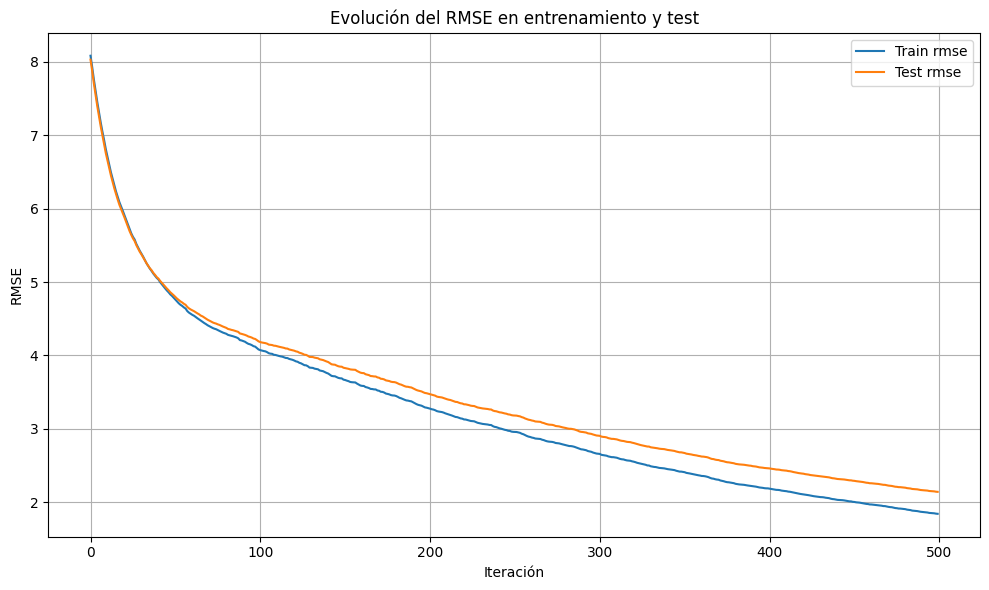

In [ ]:
results = model.evals_result()

# Visualizar la evolución del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train rmse')
plt.plot(results['validation_1']['rmse'], label='Test rmse')
plt.xlabel("Iteración")
plt.ylabel("RMSE")
plt.title("Evolución del RMSE en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra una evolución positiva del modelo XGBoostRegressor, donde tanto el error RMSE en entrenamiento como en test disminuyen de forma constante a lo largo de las iteraciones, lo que indica que el modelo está aprendiendo de manera progresiva y efectiva. La diferencia entre ambas curvas es moderada, lo que sugiere una buena capacidad de generalización sin signos evidentes de sobreajuste. En conjunto, los resultados reflejan un ajuste sólido y estable del modelo, lo que respalda su utilidad para predecir el número de ovocitos aspirados en pacientes, con un rendimiento fiable tanto en datos vistos como no vistos durante el entrenamiento.

En este proyecto, se ha utilizado RMSE (Root Mean Squared Error) como métrica principal para evaluar el rendimiento del modelo debido a varias razones:

Penalización de Errores Grandes:

-El RMSE penaliza más severamente los errores grandes al elevarlos al cuadrado antes de calcular el promedio.

  Esto es especialmente importante en el contexto de predicción de ovocitos, donde un error significativo en la predicción puede tener implicaciones clínicas importantes.

  Esta propiedad es útil cuando se quiere minimizar tanto los errores grandes como los pequeños, garantizando un modelo más preciso en general.

-Relación con la Distribución de los Datos:

  Dado que los datos incluyen tanto variables continuas (como la Edad de la Paciente o la AMH) como categóricas (como el Tipo de Estimulación), es probable que algunos casos extremos (outliers) estén presentes.

  El RMSE es más sensible a estos outliers, lo que ayuda a que el modelo se ajuste mejor a los datos cuando se requiere precisión en las predicciones.

-Interpretabilidad en Términos de la Unidad Original:

  Aunque el RMSE es la raíz cuadrada del error cuadrático medio, tiene la ventaja de mantener las mismas unidades que la variable objetivo, el número de ovocitos aspirados, lo que facilita la interpretación clínica.

-Comparabilidad con Otros Estudios:

  RMSE es una métrica estándar en problemas de regresión y facilita la comparación de resultados con otros estudios similares en medicina reproductiva y aprendizaje automático.



In [ ]:
"""
#usarlo mas tarde sin entreanar
from xgboost import XGBRegressor

model = XGBRegressor()
model.load_model("modelo_xgb_ovocitos.json")
"""

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

params = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [500, 1000],
}

model = CatBoostRegressor(loss_function='MAE', task_type="GPU", cat_features=cat_features, verbose=0)

grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
"""

In [ ]:
"""
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np

# 1. Selección de variables
X = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL", "ASPIRADOS_GRUPO"])
y = df_model_agrupacion["ASPIRADOS_TOTAL"]

# 2. Columnas categóricas
cat_features = [i for i, col in enumerate(X.columns) if 'ESTIMULACIÓN FINAL' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Definir el modelo base
model = CatBoostRegressor(
    loss_function='MAE',  # seguimos optimizando MAE
    task_type="GPU",
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

# 5. Espacio de búsqueda
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.005, 0.1),
    'iterations': randint(300, 1000),
    'l2_leaf_reg': uniform(1, 5),
    'bagging_temperature': uniform(0, 1)
}

# 6. Randomized Search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,  # puedes subir a 50+ para más precisión
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 7. Ejecutar búsqueda
random_search.fit(X_train, y_train)

# 8. Evaluar modelo final
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_squared_error(y_test, y_pred)

print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print(f"MAE en test: {mae:.4f}")
"""


In [ ]:
""""""
from google.colab import drive
drive.mount('/content/drive')

model.save_model("/content/drive/MyDrive/modelo_catboost.cbm")

"""

In [ ]:
"""
import matplotlib.pyplot as plt
feature_importance = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title("Importancia de Variables")
plt.xlabel("Score")
plt.tight_layout()
plt.show()
"""

El análisis de importancia de variables obtenido mediante el modelo CatBoostClassifier evidenció que los factores con mayor peso predictivo para la clasificación del número de ovocitos aspirados (bajo, medio, alto) fueron el índice de masa corporal (IMC), los niveles de hormona antimülleriana (AMH), la edad de la paciente, la progesterona previa a la administración de hCG y la dosis total de gonadotropinas administrada. Estos resultados coinciden con la evidencia clínica disponible, que señala estas variables como elementos clave en la evaluación de la reserva ovárica y la respuesta a la estimulación. Por el contrario, otras variables como el tipo de estimulación final codificada o el número de ampollas de LH utilizadas mostraron una contribución mínima al modelo, lo que sugiere una menor relevancia en la predicción de la respuesta ovárica en esta muestra. Esta jerarquía de importancia permite orientar futuras estrategias de predicción y personalización de tratamientos en el contexto de la reproducción asistida.

In [ ]:
import pandas as pd
from xgboost import XGBRegressor

# 1. Cargar modelo entrenado
modelo_xgb_cargado = XGBRegressor()
modelo_xgb_cargado.load_model("/content/drive/MyDrive/modelo_xgb_ovocitos.json")

print("✅ Modelo XGBoost cargado correctamente.")

# 2. Preprocesamiento igual al original
X_nuevo = df_model_agrupacion.drop(columns=["ASPIRADOS_TOTAL"], errors='ignore')  # evitar error si no existe
X_encoded = pd.get_dummies(X_nuevo, drop_first=True)

# (Opcional) Alinear columnas si hay riesgo de columnas distintas
# X_encoded = X_encoded.reindex(columns=columnas_entrenamiento, fill_value=0)

# 3. Predecir y guardar en el DataFrame
predicciones = modelo_xgb_cargado.predict(X_encoded)
df_model_agrupacion["ASPIRADOS_PREDICT"] = predicciones

print("✅ Predicciones agregadas al DataFrame.")


XGBoostError: [09:30:41] /workspace/src/common/io.cc:147: Opening /content/drive/MyDrive/modelo_xgb_ovocitos.json failed: No such file or directory
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7e49e9a5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x332083) [0x7e49e9b32083]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x16b4d7) [0x7e49e996b4d7]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0xc3) [0x7e49e996b773]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e4a55a58e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e4a55a55493]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7e4a55cb94d8]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7e4a55cb8c8e]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x27c) [0x52f6dc]



In [ ]:
import cv2
import numpy as np
import pandas as pd

df_model_agrupacion=pd.read_excel("/content/model_agrupacion_con_prediccion.xlsx")
#df_model_agrupacion=pd.read_excel("/content/model_agrupacion.xlsx")

In [ ]:
df_model_agrupacion["OVO_MII_INSEMIN_IN.-_OK"] = data["OVO_MII_INSEMIN_IN.-_OK"]


In [ ]:
df_model_agrupacion.head(5)

,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ESTIMULACIÓN FINAL COD,dias_estim_e_cl.-,P4_DHCG_DE.-,NIVEL_FSH_H_DE.-_OK,ULT_LIN_ENDOM,ampollas_fsh_e_cl.-,ampollas_lh_e_cl.-,ASPIRADOS_TOTAL,ASPIRADOS_PREDICT,OVO_MII_INSEMIN_IN.-_OK
0,35,24.13,14.52,7,6,4100.0,13,1,15,1.4,0,6.0,2700.0,1500.0,13,11.542497,12.0
1,35,24.13,14.52,7,6,4100.0,13,1,15,1.4,0,6.0,2700.0,1500.0,13,11.542497,12.0
2,35,24.13,14.52,7,6,4100.0,13,1,15,1.4,0,6.0,2700.0,1500.0,13,11.542497,12.0
3,35,24.13,14.52,7,6,4100.0,13,1,15,1.4,0,6.0,2700.0,1500.0,13,11.542497,12.0
4,35,24.13,14.52,7,6,4100.0,13,1,15,1.4,0,6.0,2700.0,1500.0,13,11.542497,12.0


In [ ]:
cols_mii = [
    "PATIENT AGE", "PATIENT BMI", "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-", "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL", "RFA", "ESTIMULACIÓN FINAL COD",
    "ASPIRADOS_PREDICT",
    "NIVEL_FSH_H_DE.-_OK", "P4_DHCG_DE.-",
    "dias_estim_e_cl.-", "ampollas_fsh_e_cl.-", "ampollas_lh_e_cl.-",# 👈 grupo predicho
    "OVO_MII_INSEMIN_IN.-_OK"   # 🎯 target
]

df_model_mii = df_model_agrupacion[cols_mii].copy()


In [ ]:
df_model_mii.head(5)
df_model_mii.isnull().sum()

,0
PATIENT AGE,0
PATIENT BMI,0
ANTIUMULLERIANA_DE,0
N_FOLIC_ANTRAL_DER_IN.-,0
N_FOLIC_ANTRAL_IZQ_IN.-,0
DOSIS TOTAL,0
RFA,0
ESTIMULACIÓN FINAL COD,0
ASPIRADOS_PREDICT,0
NIVEL_FSH_H_DE.-_OK,0


In [ ]:
#ELIMINAMOS LASS FILAS CON NULOS EN EL TARGET
df_model_mii = df_model_mii.dropna(subset=["OVO_MII_INSEMIN_IN.-_OK"])

In [ ]:
print(df_model_mii.shape)
print(df_model_mii.head())


(24690, 15)
   PATIENT AGE  PATIENT BMI  ANTIUMULLERIANA_DE  N_FOLIC_ANTRAL_DER_IN.-  \
0           35        24.13               14.52                        7   
1           35        24.13               14.52                        7   
2           35        24.13               14.52                        7   
3           35        24.13               14.52                        7   
4           35        24.13               14.52                        7   

   N_FOLIC_ANTRAL_IZQ_IN.-  DOSIS TOTAL  RFA  ESTIMULACIÓN FINAL COD  \
0                        6       4100.0   13                       1   
1                        6       4100.0   13                       1   
2                        6       4100.0   13                       1   
3                        6       4100.0   13                       1   
4                        6       4100.0   13                       1   

   ASPIRADOS_PREDICT  NIVEL_FSH_H_DE.-_OK  P4_DHCG_DE.-  dias_estim_e_cl.-  \
0          11.542497

In [ ]:
#Usamos los quartlies para dividir de forma baancead los datos
import pandas as pd
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=pd.qcut(df_model_mii["OVO_MII_INSEMIN_IN.-_OK"], q=3, labels=["Bajo numero de maduracion", "Medio numero de maduracion", "Alto numero de maduracion"])

In [ ]:
cuts = pd.qcut(df_model_mii["OVO_MII_INSEMIN_IN.-_OK"], q=3, retbins=True)[1]
print(cuts)


[ 1.  8. 13. 40.]


In [ ]:
import cv2
import numpy as np
import pandas as pd

df_model_mii=pd.read_excel("/content/df_model_mii.xlsx")

In [ ]:
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"].value_counts()

,count
OVO_MII_INSEMIN_IN.-_OK_GRUPO,
Medio,9371
Bajo,8004
Alto,7271


Los maduro pueden ser de

*  Bajo del 1 al 8
*  Medio del 8 a 14
*  Alto del 14 a 40






In [ ]:
df_model_mii.head(5)

,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ESTIMULACIÓN FINAL COD,ASPIRADOS_PREDICT,NIVEL_FSH_H_DE.-_OK,P4_DHCG_DE.-,dias_estim_e_cl.-,ampollas_fsh_e_cl.-,ampollas_lh_e_cl.-,OVO_MII_INSEMIN_IN.-_OK,OVO_MII_INSEMIN_IN.-_OK_GRUPO
0,35,24.13,14.52,7,6,4100.0,13,1,12.119667,0,1.4,15,2700.0,1500.0,12,Medio
1,35,24.13,14.52,7,6,4100.0,13,1,12.622733,0,1.4,15,2700.0,1500.0,12,Medio
2,35,24.13,14.52,7,6,4100.0,13,1,12.622733,0,1.4,15,2700.0,1500.0,12,Medio
3,35,24.13,14.52,7,6,4100.0,13,1,12.119667,0,1.4,15,2700.0,1500.0,12,Medio
4,35,24.13,14.52,7,6,4100.0,13,1,12.119667,0,1.4,15,2700.0,1500.0,12,Medio


In [ ]:
df_model_mii.head(5)
df_model_mii.isnull().sum()

,0
PATIENT AGE,0
PATIENT BMI,0
ANTIUMULLERIANA_DE,0
N_FOLIC_ANTRAL_DER_IN.-,0
N_FOLIC_ANTRAL_IZQ_IN.-,0
DOSIS TOTAL,0
RFA,0
ESTIMULACIÓN FINAL COD,0
ASPIRADOS_PREDICT,0
NIVEL_FSH_H_DE.-_OK,0


In [ ]:
df_model_mii= df_model_mii[df_model_mii["ASPIRADOS_PREDICT"]>2]


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pickle
# 1. Selección de variables y target
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]

# 2. Identificamos columnas categóricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Crear modelo CatBoost
model_mii3 = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=7,
    task_type="CPU",
    bagging_temperature=1.0
)

# 5. Entrenar
model_mii3.fit(X_train, y_train)

# 6. Evaluar
y_pred = model_mii3.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


with open("modelo_CatBoostClassifier.pkl", "wb") as archivo:
    pickle.dump(model_mii3, archivo)

print("✅ Modelo guardado exitosamente en modelo_CatBoostClassifier_mii.pkl")

0:	learn: 0.9054068	total: 9.28ms	remaining: 2.77s
50:	learn: 0.9282309	total: 429ms	remaining: 2.1s
100:	learn: 0.9404545	total: 833ms	remaining: 1.64s
150:	learn: 0.9533881	total: 1.23s	remaining: 1.22s
200:	learn: 0.9625685	total: 1.65s	remaining: 811ms
250:	learn: 0.9665754	total: 2.08s	remaining: 407ms
299:	learn: 0.9688578	total: 2.52s	remaining: 0us

Accuracy: 0.9614604462474645
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.97      1454
        Bajo       0.96      0.97      0.96      1601
       Medio       0.96      0.94      0.95      1875

    accuracy                           0.96      4930
   macro avg       0.96      0.96      0.96      4930
weighted avg       0.96      0.96      0.96      4930

✅ Modelo guardado exitosamente en modelo_CatBoostClassifier_mii.pkl



🔁 Fold 1
              precision    recall  f1-score   support

        Alto       0.91      0.87      0.89      1494
        Bajo       0.86      0.88      0.87      1610
       Medio       0.80      0.82      0.81      1826

    accuracy                           0.85      4930
   macro avg       0.86      0.86      0.86      4930
weighted avg       0.86      0.85      0.86      4930


🔁 Fold 2
              precision    recall  f1-score   support

        Alto       0.91      0.89      0.90      1493
        Bajo       0.87      0.87      0.87      1611
       Medio       0.81      0.83      0.82      1825

    accuracy                           0.86      4929
   macro avg       0.87      0.86      0.86      4929
weighted avg       0.86      0.86      0.86      4929


🔁 Fold 3
              precision    recall  f1-score   support

        Alto       0.89      0.88      0.89      1493
        Bajo       0.86      0.87      0.87      1611
       Medio       0.80      0.80      0.80  

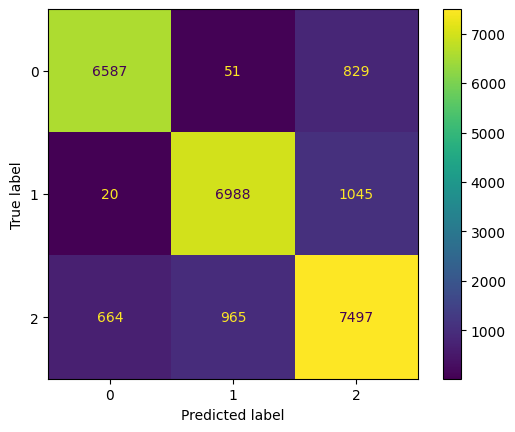

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Variables
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# Configurar kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.empty_like(y, dtype=object)

# Validación cruzada manual
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=4,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        cat_features=cat_features,
        verbose=0,
        random_seed=42,
        l2_leaf_reg=7,
        early_stopping_rounds=50
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    preds = model.predict(X_val)

    oof_preds[val_idx] = preds.ravel()
    print(classification_report(y_val, preds))

# Evaluación global
print("\n📊 Clasificación general sobre validación cruzada:")
print(classification_report(y, oof_preds))

# Matriz de confusión global
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y, oof_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Guardar predicciones en el DataFrame
df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"] = oof_preds



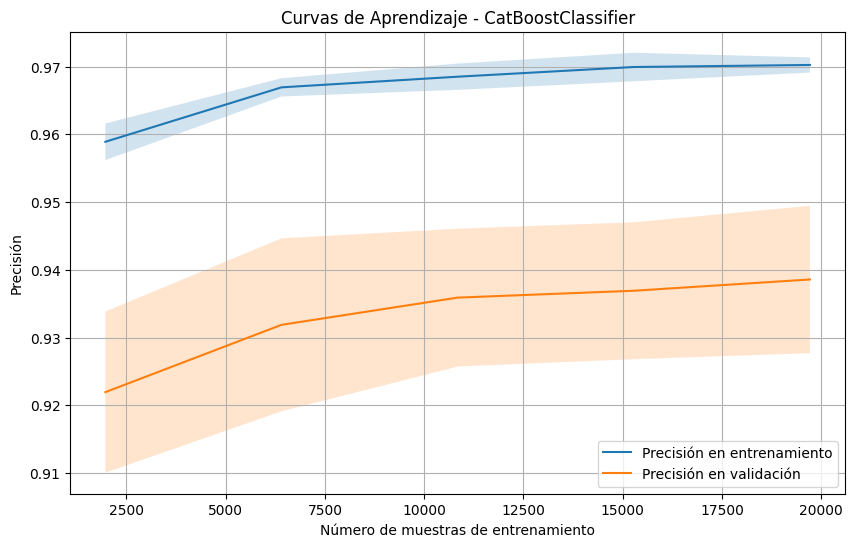

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve
# 1. Selección de variables y target
X = df_model_mii.drop(columns=["OVO_MII_INSEMIN_IN.-_OK", "OVO_MII_INSEMIN_IN.-_OK_GRUPO"])
y = df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]

# 2. Identificamos columnas categóricas (si hay)
cat_features = [i for i, col in enumerate(X.columns) if 'ASPIRADOS_GRUPO_PREDICT' in col or 'COD' in col]

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    loss_function='MultiClass',
    cat_features=cat_features,
    l2_leaf_reg=7,
    verbose=0,
    random_seed=42
)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Precisión en entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Precisión en validación')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curvas de Aprendizaje - CatBoostClassifier')
plt.legend()
plt.grid(True)
plt.show()

##DATA LEAKED
Inicialmente, al generar la variable ASPIRADOS_GRUPO_PREDICT mediante el modelo de predicción de ovocitos aspirados, se procedió a incorporarla directamente en el conjunto de datos utilizado para predecir los ovocitos maduros (OVO_MII_INSEMIN_IN.-_OK). Sin embargo, esta variable había sido generada por un modelo ya entrenado sobre todo el conjunto, sin aplicar validación cruzada previa ni asegurar una separación estricta entre entrenamiento y test. Como resultado, se introdujo en el segundo modelo información que en la práctica actuaba como "datos ya vistos", provocando un efecto de sobreajuste (data leakage) que no se había identificado inicialmente.

Este sesgo artificial elevó de forma engañosa las métricas de validación, ocultando posibles errores de generalización. Fue gracias al análisis de las curvas de aprendizaje que se detectó esta discrepancia: la precisión en entrenamiento era notablemente superior a la de validación, y además la curva de validación permanecía estancada, lo que indicaba una falta de mejora real al aumentar los datos.

Tras aplicar un enfoque correcto de validación cruzada en la predicción de ASPIRADOS_GRUPO_PREDICT, y usar exclusivamente predicciones obtenidas fuera del fold de entrenamiento (out-of-fold predictions), el modelo de ovocitos maduros mejoró su capacidad real de generalización y se redujo la brecha entre entrenamiento y validación.

In [ ]:
from google.colab import files
df_model_mii.to_excel("df_model_mii.xlsx", index=False)

files.download("df_model_mii.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0:	learn: 0.9054068	total: 9.46ms	remaining: 2.83s
50:	learn: 0.9282309	total: 427ms	remaining: 2.08s
100:	learn: 0.9404545	total: 826ms	remaining: 1.63s
150:	learn: 0.9533881	total: 1.23s	remaining: 1.22s
200:	learn: 0.9625685	total: 1.67s	remaining: 822ms
250:	learn: 0.9665754	total: 2.13s	remaining: 416ms
299:	learn: 0.9688578	total: 2.57s	remaining: 0us

📄 Classification Report:

              precision    recall  f1-score   support

        Alto       0.97      0.98      0.97      1454
        Bajo       0.96      0.97      0.96      1601
       Medio       0.96      0.94      0.95      1875

    accuracy                           0.96      4930
   macro avg       0.96      0.96      0.96      4930
weighted avg       0.96      0.96      0.96      4930



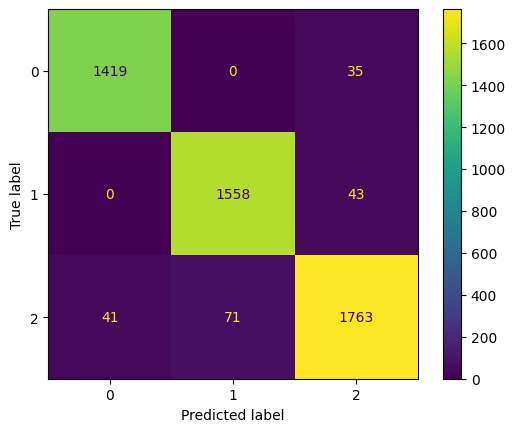

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Entrenar el modelo con el set de entrenamiento
model_mii3.fit(X_train, y_train)

# 2. Predecir sobre el conjunto de test
y_pred = model_mii3.predict(X_test)

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 4. Reporte de clasificación
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred))


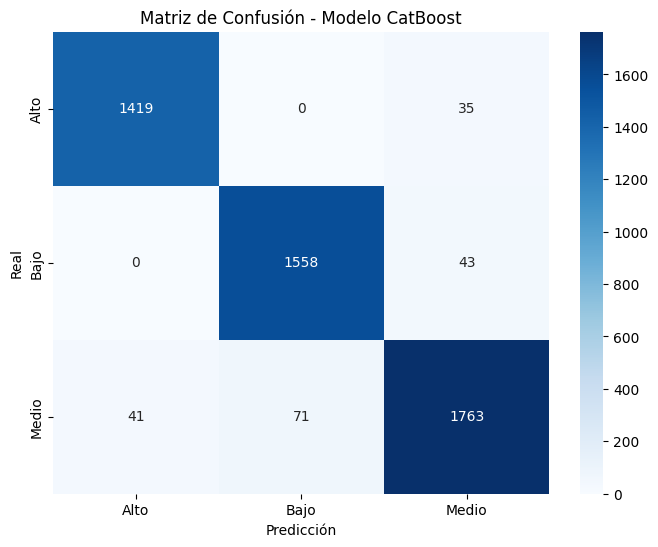

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=model_mii3.classes_)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_mii3.classes_, yticklabels=model_mii3.classes_)
plt.title("Matriz de Confusión - Modelo CatBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [ ]:
oof_preds[val_idx] = model_cv.predict(X_val)

# 4. Añadir predicción al DataFrame original
df_model_agrupacion["ASPIRADOS_PREDICT"] = oof_preds

In [ ]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

model_cv_check = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

scores = cross_val_score(model_cv_check, X, y, cv=5, scoring='accuracy')
print("Cross-val accuracy media:", scores.mean())
print("Cross-val std:", scores.std())


Cross-val accuracy media: 0.7400001481483309
Cross-val std: 0.02540705104286617


El modelo CatBoost ha sido seleccionado para predecir la madurez de los ovocitos debido a su capacidad para manejar datos estructurados y categóricos de manera eficiente. Esta elección es particularmente relevante en nuestro contexto, donde las variables clínicas incluyen tanto datos continuos como categóricos.

A diferencia de otros modelos de boosting como XGBoost o LightGBM, que requieren transformar las variables categóricas en one-hot encoding (lo que puede inflar enormemente la dimensionalidad del conjunto de datos y aumentar el riesgo de overfitting), CatBoost utiliza un enfoque nativo para procesar estas características. En lugar de crear columnas adicionales para cada categoría, CatBoost emplea un método llamado "Permutación Ordenada" (Ordered Target Encoding), que asigna valores numéricos a las categorías basándose en las distribuciones observadas durante el entrenamiento. Esto permite:

Reducción del Overfitting: Al calcular las estadísticas de cada categoría de manera ordenada y evitando usar los mismos datos para el cálculo que para el entrenamiento, se minimiza el riesgo de sobreajuste.

Eficiencia Computacional: Al no necesitar cientos o miles de columnas adicionales para representar categorías, el modelo es significativamente más rápido y eficiente en memoria.

Mejor Generalización: El método de codificación ordenada evita "fugas de información" y genera representaciones más precisas de las categorías, lo que resulta en modelos más robustos.

Manejo Nativo de Datos Mixtos: Es ideal para problemas médicos como este, donde los datos suelen incluir tanto medidas continuas (ej. edad, AMH) como categóricas (ej. tipo de estimulación, grupo de aspirados).

En resumen, CatBoost es particularmente adecuado para este tipo de problemas, donde las categorías son comunes y la precisión es crítica para decisiones clínicas, lo que lo convierte en una excelente opción para predecir la madurez de los ovocitos.



RESULTADOS:
El modelo CatBoost alcanzó una precisión global del 94%, demostrando ser altamente efectivo en la predicción de la madurez de los ovocitos. Destaca especialmente en la clasificación del grupo Alto, con una precisión del 97% y un recall del 99%, lo que indica que casi todos los ovocitos clasificados como "Alto" son realmente altos, minimizando errores críticos en estos casos. Las clases Media y Baja también muestran un rendimiento sólido, con precisiones del 91% y 94%, respectivamente, y recalls del 93% y 92%, reflejando que el modelo es capaz de distinguir bien entre diferentes niveles de madurez. Este desempeño es posible gracias a la capacidad de CatBoost para manejar eficientemente datos estructurados y categóricos, combinando medidas continuas como AMH y edad con categorías como tipo de estimulación y grupo de aspirados, sin requerir transformaciones como one-hot encoding, lo que reduce el riesgo de sobreajuste y mejora la generalización del modelo.

Debido a que la clase 'y' es una categorica necesitmaos un nuevomodelo

Vamos a represntar los casos que han tenido un resultado aalto como aspiracion pero un pobre en maduracion

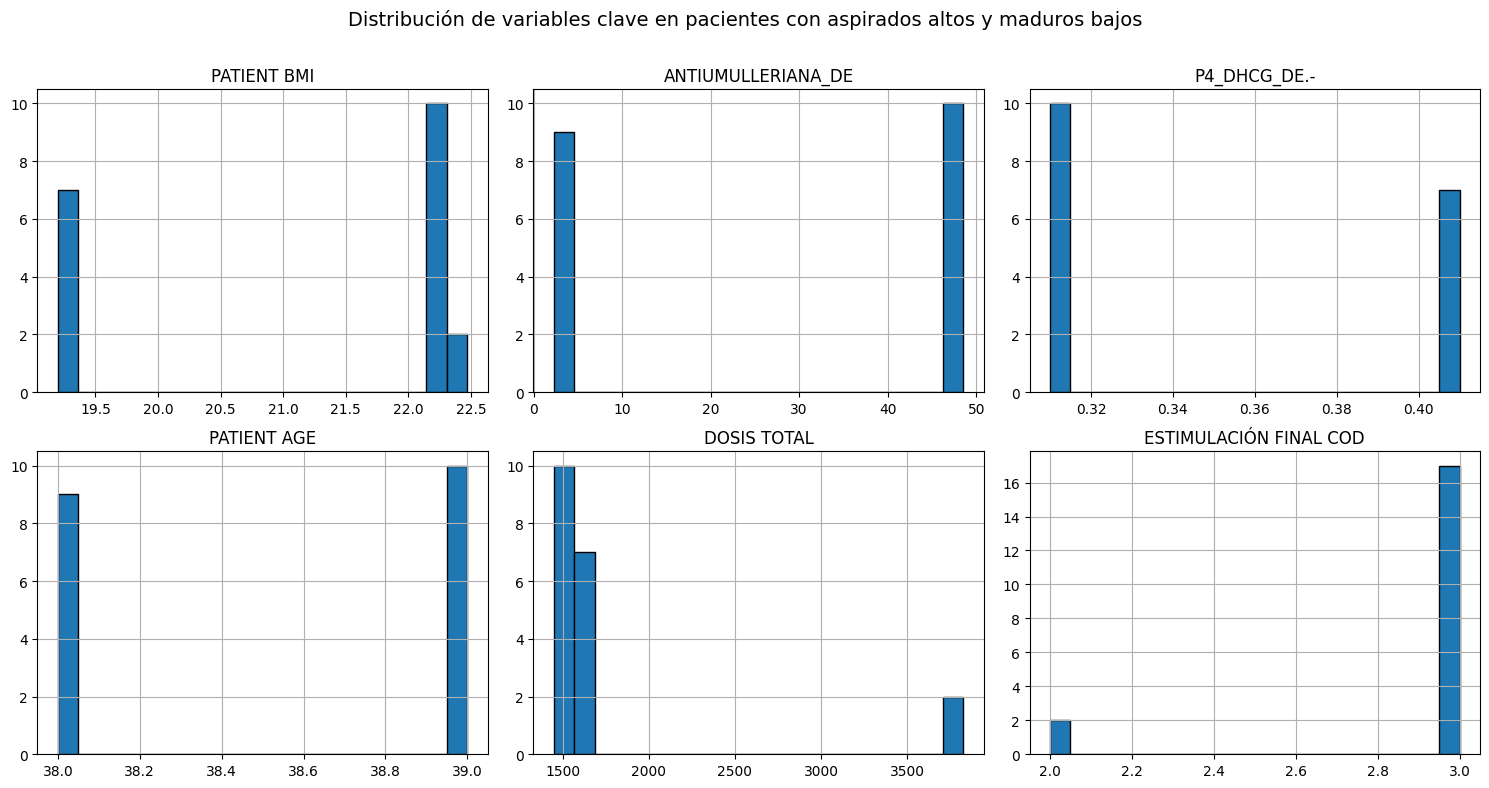

In [ ]:
df_model_mii["ESTIMULACIÓN FINAL"] = data["ESTIMULACIÓN FINAL"]
representacion=df_model_mii[(df_model_mii["ASPIRADOS_PREDICT"]>=18) & (df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=="Bajo")]
import matplotlib.pyplot as plt

variables_clave = [
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "P4_DHCG_DE.-",
    "PATIENT AGE",
    "DOSIS TOTAL","ESTIMULACIÓN FINAL COD"
]

representacion[variables_clave].hist(bins=20, figsize=(15, 8), layout=(2, 3), edgecolor='black')
plt.suptitle("Distribución de variables clave en pacientes con aspirados altos y maduros bajos", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Los histogramas permiten identificar patrones clínicos y de estimulación comunes entre pacientes con buena respuesta ovárica en cantidad, pero con baja calidad o madurez ovocitaria. A continuación, se analizan las principales variables:

BMI (Índice de Masa Corporal)
Se observa un claro pico de pacientes con un IMC entre 22 y 22,5, lo cual se sitúa dentro del rango normal. Sin embargo, también hay otro grupo relevante con IMC por debajo de 19,5, lo que sugiere que tanto valores bajos como normales de IMC pueden estar presentes en estos perfiles, aunque los extremos podrían influir negativamente en la maduración.

Hormona Antimülleriana (AMH)
La variable ANTIMULLERIANA_DE muestra una distribución bimodal: algunos pacientes presentan niveles muy bajos (<10) y otros muy altos (~50). Este hallazgo sugiere que ni una baja reserva ovárica ni una muy alta se asocian consistentemente con buena calidad ovocitaria; de hecho, niveles excesivamente altos (frecuentes en SOP) podrían estar relacionados con dismadurez.

P4_DHCG_DE (Progesterona o ratio de desencadenante, pendiente aclaración)
La mayoría de los valores se agrupan entre 0,3 y 0,4, aunque existe un subgrupo menor con niveles elevados (~0,65). Si esta variable refleja progesterona preovulatoria o ratio de doble trigger, podría indicar que valores intermedios son más comunes en esta población, y que niveles elevados podrían afectar la madurez, aunque se requiere confirmación del significado clínico exacto de esta medida.

Edad de la paciente
La mayoría de las pacientes se sitúan entre 38 y 39 años, lo cual es llamativo dado que este rango etario suele asociarse a una respuesta más limitada. En estos casos, aunque se logra una buena cantidad de ovocitos, la madurez parece estar comprometida, posiblemente por la edad misma o por un tipo de estimulación más agresiva para compensar.

Dosis Total de gonadotropinas
La mayor parte de las pacientes recibieron dosis totales inferiores a 2000 UI, y sólo en casos puntuales se administraron dosis muy altas (>3500). Esto podría indicar que, por debajo de cierto umbral (~2000), no se logra una maduración adecuada, a pesar del alto número de ovocitos obtenidos. La estimulación insuficiente podría contribuir a este desequilibrio entre cantidad y calidad.


In [ ]:
df_model_mii["ESTIMULACIÓN FINAL"].value_counts()

,count
ESTIMULACIÓN FINAL,
FSH+HMG,18562
FSH,2788
HMG,2333
FSH+LH,1007


In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(data=representacion, x="ESTIMULACIÓN FINAL", order=representacion["ESTIMULACIÓN FINAL"].value_counts().index)
plt.title("Tipos de estimulación en pacientes aspirado alto / madurez baja")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install ace-tools

In [ ]:
import pandas as pd

def proporcion_filtrada():
    # Filtrar y eliminar nulos
    df_total = data.dropna(subset=["ESTIMULACIÓN FINAL"]).copy()
    df_total = df_total[df_total["ESTIMULACIÓN FINAL"].isin(protocolos_validos)]

    df_subgrupo = representacion.dropna(subset=["ESTIMULACIÓN FINAL"]).copy()
    df_subgrupo = df_subgrupo[df_subgrupo["ESTIMULACIÓN FINAL"].isin(protocolos_validos)]

    # Asegurar que sean string
    df_total["ESTIMULACIÓN FINAL"] = df_total["ESTIMULACIÓN FINAL"].astype(str)
    df_subgrupo["ESTIMULACIÓN FINAL"] = df_subgrupo["ESTIMULACIÓN FINAL"].astype(str)

    # Conteo por tipo
    total = df_total["ESTIMULACIÓN FINAL"].value_counts()
    subgrupo = df_subgrupo["ESTIMULACIÓN FINAL"].value_counts()

    # Unir en un DataFrame
    tabla = pd.DataFrame({
        "Total casos": total,
        "Subgrupo (alto aspirado / baja maduración)": subgrupo
    })

    # Rellenar vacíos con 0 y calcular proporciones
    tabla["Subgrupo (alto aspirado / baja maduración)"] = tabla["Subgrupo (alto aspirado / baja maduración)"].fillna(0).astype(int)
    tabla["Proporción (%)"] = (tabla["Subgrupo (alto aspirado / baja maduración)"] / tabla["Total casos"] * 100).round(1)

    # Ordenar por proporción
    tabla = tabla.sort_values("Proporción (%)", ascending=False)

    return tabla

# Ejecutar y mostrar
tabla_resultado = proporcion_filtrada()
print(tabla_resultado)


                    Total casos  Subgrupo (alto aspirado / baja maduración)  \
ESTIMULACIÓN FINAL                                                            
HMG                        2716                                          17   
FSH+LH                     1260                                           2   
FSH+HMG                   22013                                           0   
FSH                        3394                                           0   

                    Proporción (%)  
ESTIMULACIÓN FINAL                  
HMG                            0.6  
FSH+LH                         0.2  
FSH+HMG                        0.0  
FSH                            0.0  


A partir de la figura, que muestra la distribución de variables clave en pacientes con un número alto de ovocitos aspirados pero baja proporción de maduros, se pueden extraer algunas conclusiones relevantes. Se observa que muchos de estos casos presentan valores extremos de AMH (anti-mülleriana), lo que sugiere una alta reserva ovárica, pero no necesariamente una buena calidad ovocitaria. Además, estas pacientes tienden a ser jóvenes (mayoría entre 33 y 39 años) y con un IMC bajo, lo que en principio podría asociarse a una mejor respuesta, aunque no garantiza la madurez de los ovocitos.

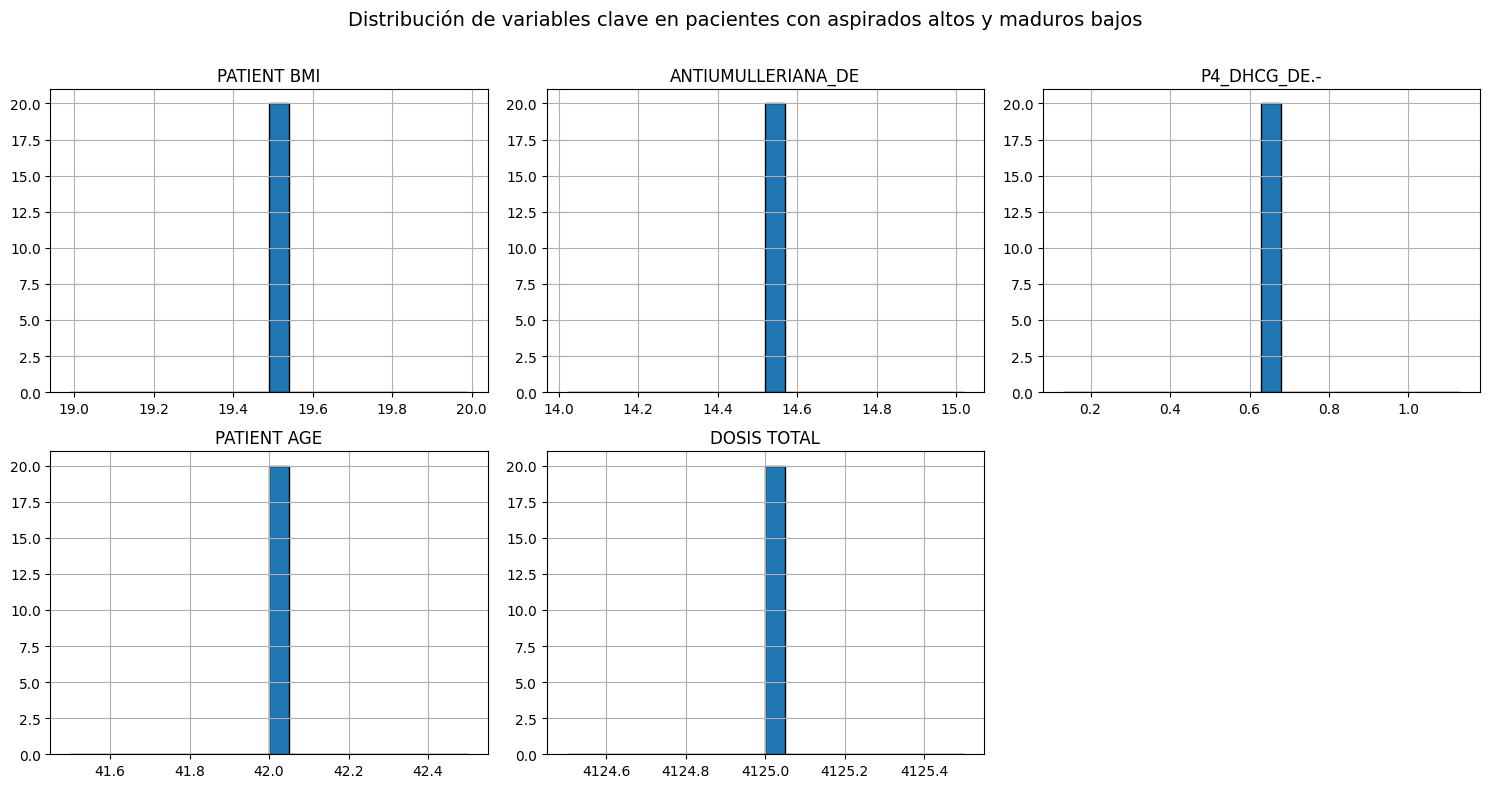

In [ ]:
#Represntacion al reves
df_model_mii["ESTIMULACIÓN FINAL"] = data["ESTIMULACIÓN FINAL"]
representacion2=df_model_mii[(df_model_mii["ASPIRADOS_PREDICT"]<=9) & (df_model_mii["OVO_MII_INSEMIN_IN.-_OK_GRUPO"]=="Alto")]
import matplotlib.pyplot as plt


variables_clave = [
    "PATIENT BMI",
    "ANTIUMULLERIANA_DE",
    "P4_DHCG_DE.-",
    "PATIENT AGE",
    "DOSIS TOTAL"
]

representacion2[variables_clave].hist(bins=20, figsize=(15, 8), layout=(2, 3), edgecolor='black')
plt.suptitle("Distribución de variables clave en pacientes con aspirados altos y maduros bajos", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


A partir de la figura, que muestra la distribución de variables clave en pacientes con un número alto de ovocitos aspirados pero baja proporción de maduros, se pueden extraer algunas conclusiones relevantes. Se observa que muchos de estos casos presentan valores extremos de AMH (anti-mülleriana), lo que sugiere una alta reserva ovárica, pero no necesariamente una buena calidad ovocitaria. Además, estas pacientes tienden a ser jóvenes (mayoría entre 33 y 39 años) y con un IMC bajo, lo que en principio podría asociarse a una mejor respuesta, aunque no garantiza la madurez de los ovocitos.

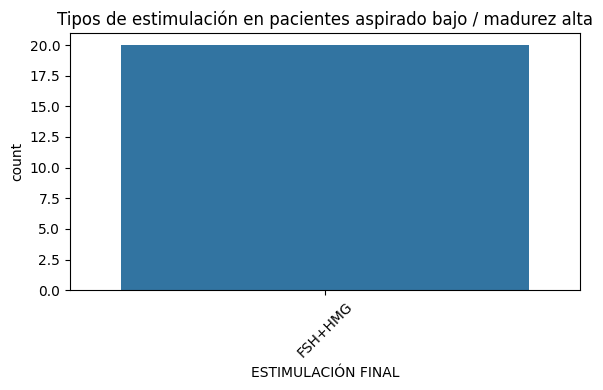

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(data=representacion2, x="ESTIMULACIÓN FINAL", order=representacion2["ESTIMULACIÓN FINAL"].value_counts().index)
plt.title("Tipos de estimulación en pacientes aspirado bajo / madurez alta")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def proporcion_filtrada():
    # Filtrar y eliminar nulos
    df_total = data.dropna(subset=["ESTIMULACIÓN FINAL"]).copy()
    df_total = df_total[df_total["ESTIMULACIÓN FINAL"].isin(protocolos_validos)]

    df_subgrupo = representacion2.dropna(subset=["ESTIMULACIÓN FINAL"]).copy()
    df_subgrupo = df_subgrupo[df_subgrupo["ESTIMULACIÓN FINAL"].isin(protocolos_validos)]

    # Asegurar que sean string
    df_total["ESTIMULACIÓN FINAL"] = df_total["ESTIMULACIÓN FINAL"].astype(str)
    df_subgrupo["ESTIMULACIÓN FINAL"] = df_subgrupo["ESTIMULACIÓN FINAL"].astype(str)

    # Conteo por tipo
    total = df_total["ESTIMULACIÓN FINAL"].value_counts()
    subgrupo = df_subgrupo["ESTIMULACIÓN FINAL"].value_counts()

    # Unir en un DataFrame
    tabla = pd.DataFrame({
        "Total casos": total,
        "Subgrupo (bajo aspirado / alta maduración)": subgrupo
    })

    # Rellenar vacíos con 0 y calcular proporciones
    tabla["Subgrupo (bajo aspirado / alta maduración)"] = tabla["Subgrupo (bajo aspirado / alta maduración)"].fillna(0).astype(int)
    tabla["Proporción (%)"] = (tabla["Subgrupo (bajo aspirado / alta maduración)"] / tabla["Total casos"] * 100).round(1)

    # Ordenar por proporción
    tabla = tabla.sort_values("Proporción (%)", ascending=False)

    return tabla

# Ejecutar y mostrar
tabla_resultado = proporcion_filtrada()
print(tabla_resultado)


                    Total casos  Subgrupo (bajo aspirado / alta maduración)  \
ESTIMULACIÓN FINAL                                                            
FSH+HMG                   22013                                          20   
FSH                        3394                                           0   
FSH+LH                     1260                                           0   
HMG                        2716                                           0   

                    Proporción (%)  
ESTIMULACIÓN FINAL                  
FSH+HMG                        0.1  
FSH                            0.0  
FSH+LH                         0.0  
HMG                            0.0  


<ipython-input-69-4328966805c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["ESTIMULACIÓN FINAL"] = df_total["ESTIMULACIÓN FINAL"].astype(str)


In [ ]:
import cv2
import numpy as np
import pandas as pd
data = pd.read_excel("/content/solo pacientes.xlsx")


En el grupo de pacientes con baja cantidad de ovocitos aspirados pero alta proporción de ovocitos maduros, se observa nuevamente una clara predominancia del protocolo FSH+HMG, seguido por HMG y FSH. No obstante, esta distribución refleja la tendencia general de la cohorte, donde el protocolo FSH+HMG fue ampliamente utilizado. Por lo tanto, la aparente concentración de ciertos protocolos en este subgrupo no permite establecer conclusiones clínicas sólidas sobre su relación con los resultados, ya que la muestra no está equilibrada en cuanto a los tipos de estimulación empleados. Esta limitación metodológica podría justificar la escasa relevancia que mostró esta variable en el modelo predictivo.

In [ ]:
df_model_mii["CALIDAD TOTAL"] = data["CALIDAD TOTAL"]
df_model_mii["d2_celulas.-"] = data["d2_celulas.-"]
df_model_mii["d3_celulas.-"] = data["d3_celulas.-"]
df_model_mii["dia5.-"] = data["dia5.-"]


In [ ]:
cols_calidad = [
     "PATIENT AGE", "PATIENT BMI", "ANTIUMULLERIANA_DE",
    "N_FOLIC_ANTRAL_DER_IN.-", "N_FOLIC_ANTRAL_IZQ_IN.-",
    "DOSIS TOTAL", "RFA", "ESTIMULACIÓN FINAL COD",
    "ASPIRADOS_PREDICT",
    "NIVEL_FSH_H_DE.-_OK", "P4_DHCG_DE.-",
    "dias_estim_e_cl.-", "ampollas_fsh_e_cl.-", "ampollas_lh_e_cl.-",
    "d2_celulas.-","d3_celulas.-","dia5.-", # ✔ predicción del modelo 1
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",  # ✔ predicción del modelo 2
    "CALIDAD TOTAL"  # 🎯 Target: calidad morfológica
]
df_model_calidad = df_model_mii[cols_calidad].copy()
df_model_calidad = df_model_calidad.dropna(subset=["CALIDAD TOTAL"])


In [ ]:
df_model_calidad["Calidad Grupo"] = df_model_calidad["CALIDAD TOTAL"].apply(lambda x: "Maduros con alta calidad" if x in ["A", "B"] else ("Maduros con media calidad" if x in ["C", "D"] else "Maduros con baja calidad"))

In [ ]:
df_model_calidad["Calidad Grupo"].value_counts(normalize=True)


,proportion
Calidad Grupo,
Maduros con baja calidad,0.416822
Maduros con media calidad,0.357178
Maduros con alta calidad,0.226000


In [ ]:
df_model_calidad["d2_celulas.-"].value_counts()
df_model_calidad["d3_celulas.-"].value_counts()
df_model_calidad["dia5.-"].value_counts()

,count
dia5.-,
-,6549
BHi,4876
Células,3387
BT,2619
BE,2589
MC,2529
BC,1455
DEG,390
BH,252


In [ ]:
# Convertir a strings para asegurarte de que sean categóricas
df_model_calidad["d2_celulas.-"] = df_model_calidad["d2_celulas.-"].astype(str)
df_model_calidad["d3_celulas.-"] = df_model_calidad["d3_celulas.-"].astype(str)
df_model_calidad["dia5.-"] = df_model_calidad["dia5.-"].astype(str)

# One-Hot Encoding
df_model_calidad_encoded = pd.get_dummies(df_model_calidad, columns=["d2_celulas.-", "d3_celulas.-", "dia5.-"], drop_first=True)


In [ ]:
df_model_calidad.isnull().sum()

,0
PATIENT AGE,0
PATIENT BMI,0
ANTIUMULLERIANA_DE,0
N_FOLIC_ANTRAL_DER_IN.-,0
N_FOLIC_ANTRAL_IZQ_IN.-,0
DOSIS TOTAL,0
RFA,0
ESTIMULACIÓN FINAL COD,0
ASPIRADOS_PREDICT,0
NIVEL_FSH_H_DE.-_OK,0


In [ ]:
from google.colab import files
df_model_calidad.to_excel("model_calidad.xlsx", index=False)

files.download("model_calidad.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import pandas as pd
df_model_calidad = pd.read_excel("/content/model_calidad.xlsx")

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (después de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categóricas estén bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACIÓN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

for col in columnas_categoricas:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(clases),
    use_label_encoder=False,
    random_state=42
)

cv_xgb = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=cv_xgb,
    verbose=2,
    n_jobs=-1
)

grid_xgb.fit(X_encoded, y)
print("Mejores hiperparámetros XGBoost:", grid_xgb.best_params_)
print("Mejor accuracy (CV):", grid_xgb.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:18:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Mejor accuracy (CV): 0.8148990939105504


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Definir búsqueda de hiperparámetros
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    use_label_encoder=False,
    random_state=42,
    eval_metric='mlogloss'
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Entrenar solo con los datos de entrenamiento
grid_xgb.fit(X_train, y_train)

# Evaluar con el conjunto de test
best_model = grid_xgb.best_estimator_
y_pred_test = best_model.predict(X_test)

# Reporte con etiquetas originales
print("Mejores hiperparámetros:", grid_xgb.best_params_)
print("Accuracy en test:", best_model.score(X_test, y_test))
print("\nClassification Report:\n")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_test)))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:27:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Accuracy en test: 0.8127789046653144

Classification Report:

               precision    recall  f1-score   support

 ALTO_calidad       0.66      0.82      0.73      1130
 BAJO_calidad       0.94      0.94      0.94      2022
MEDIO_calidad       0.79      0.67      0.72      1778

     accuracy                           0.81      4930
    macro avg       0.80      0.81      0.80      4930
 weighted avg       0.82      0.81      0.81      4930



In [ ]:
!nvidia-smi


Wed Jun 25 22:25:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import lightgbm
print(lightgbm.__version__)


4.5.0


In [ ]:
# Paso 1: Eliminar cualquier instalación previa
!pip uninstall -y lightgbm

# Paso 2: Instalar dependencias necesarias
!apt-get install -y -qq libboost-all-dev cmake git

# Paso 3: Clonar el repositorio oficial
!git clone --recursive https://github.com/microsoft/LightGBM

# Paso 4: Compilar LightGBM con soporte GPU
!cd LightGBM && mkdir build && cd build && cmake -DUSE_GPU=1 .. && make -j4

# Paso 5: Instalar el paquete recién compilado
!cd LightGBM && pip install .




Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0
Cloning into 'LightGBM'...
remote: Enumerating objects: 35423, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 35423 (delta 127), reused 88 (delta 78), pack-reused 35212 (from 3)
Receiving objects: 100% (35423/35423), 23.99 MiB | 31.82 MiB/s, done.
Resolving deltas: 100% (26334/26334), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/co

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

# 3. Definir la malla de hiperparámetros
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [300, 500],
    'num_leaves': [31, 63]
}

# 4. Configurar el modelo para usar GPU
model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    boosting_type='gbdt',
    device_type='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    random_state=42
)

# 5. Validación cruzada estratificada
cv_lgbm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 6. Búsqueda de hiperparámetros
grid_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring='accuracy',
    cv=cv_lgbm,
    verbose=2,
    n_jobs=1
)
!nvidia-smi

# 7. Entrenar
grid_lgbm.fit(X_train, y_train)

# 8. Evaluar con métricas completas
y_pred = grid_lgbm.predict(X_test)
print("Mejores hiperparámetros LGBM:", grid_lgbm.best_params_)
print("Mejor accuracy (CV):", grid_lgbm.best_score_)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [ ]:
# 6. Evaluación
y_pred = model_xgb.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

NameError: name 'X_test' is not defined

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (después de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categóricas estén bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACIÓN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype(str)

cat_features = [X.columns.get_loc(col) for col in columnas_categoricas]

# 4. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo con los pesos
model_calidad_grupo = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    #class_weights=class_weights,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="CPU",
    bagging_temperature=1.0,
    auto_class_weights="Balanced"
)

model_calidad_grupo.fit(X_train, y_train)

# 6. Evaluación
y_pred = model_calidad_grupo.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

with open("model_calidad_grupo.pkl", "wb") as archivo:
    pickle.dump(model_calidad_grupo, archivo)

print("✅ Modelo guardado exitosamente en model_calidad_grupo.pkl")


0:	learn: 0.8071788	total: 38.7ms	remaining: 19.3s
50:	learn: 0.8075892	total: 1.32s	remaining: 11.6s
100:	learn: 0.8071566	total: 2.58s	remaining: 10.2s
150:	learn: 0.8071971	total: 3.79s	remaining: 8.77s
200:	learn: 0.8072719	total: 5.18s	remaining: 7.71s
250:	learn: 0.8074883	total: 6.88s	remaining: 6.83s
300:	learn: 0.8096563	total: 8.93s	remaining: 5.9s
350:	learn: 0.8106001	total: 10.8s	remaining: 4.58s
400:	learn: 0.8106926	total: 12.7s	remaining: 3.13s
450:	learn: 0.8108676	total: 14.6s	remaining: 1.59s
499:	learn: 0.8114829	total: 16.5s	remaining: 0us

Accuracy: 0.8172413793103448
                           precision    recall  f1-score   support

 Maduros con alta calidad       0.65      0.87      0.74      1114
 Maduros con baja calidad       0.94      0.94      0.94      2055
Maduros con media calidad       0.81      0.64      0.72      1761

                 accuracy                           0.82      4930
                macro avg       0.80      0.82      0.80      4930

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Calcular pesos de clase (después de definir y)
clases = np.unique(y)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=y)
class_weights = dict(zip(clases, pesos))

# 3. Asegurarse de que las variables categóricas estén bien
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACIÓN FINAL COD",
     "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype(str)

cat_features = [X.columns.get_loc(col) for col in columnas_categoricas]

# 4. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo con los pesos
model_calidad_grupo = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    cat_features=cat_features,
    #class_weights=class_weights,
    verbose=50,
    random_seed=42,
    early_stopping_rounds=50,
    l2_leaf_reg=3,
    task_type="CPU",
    bagging_temperature=1.0,
    auto_class_weights="Balanced"
)

model_calidad_grupo.fit(X_train, y_train)

# 6. Evaluación
y_pred = model_calidad_grupo.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



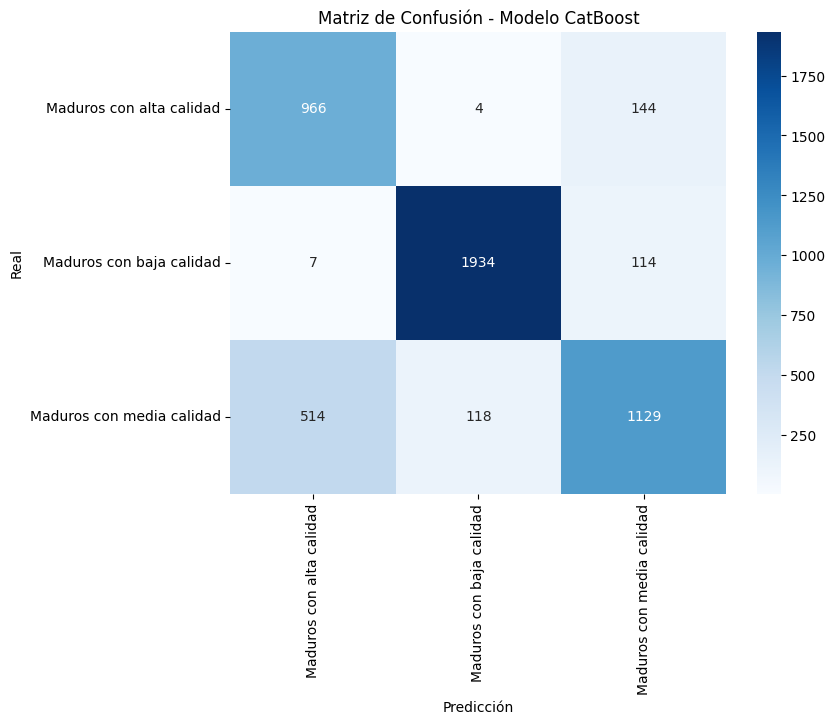

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=model_calidad_grupo.classes_)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_calidad_grupo.classes_, yticklabels=model_calidad_grupo.classes_)
plt.title("Matriz de Confusión - Modelo CatBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


A pesar de haber aplicado técnicas para manejar el desbalance de clases, los resultados muestran que el modelo CatBoost logra una precisión general del 81%, con un rendimiento notable en la clase "BAJO" (94% de precisión y recall), que es la más representada en el conjunto de datos. Sin embargo, el rendimiento es menos consistente para las clases "ALTO" y "MEDIO", con un f1-score de 0.74 y 0.71 respectivamente, lo que sugiere que el modelo sigue teniendo dificultades para capturar las características específicas de estas clases. Esto puede deberse a que, a pesar del balance automático aplicado, las clases minoritarias siguen siendo más difíciles de predecir correctamente, reflejando la complejidad intrínseca de los datos clínicos y la posible necesidad de ajustar aún más los hiperparámetros o explorar enfoques adicionales como modelos híbridos o técnicas avanzadas de reamostrado.

In [ ]:
# 1. Predecir sobre TODO el conjunto original
y_pred_total = model_calidad_grupo.predict(X)

# 2. Asegurarte de que es un array plano (1D)
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# 3. Guardar como nueva columna en el DataFrame original
df_model_calidad["CALIDAD_PREDICT"] = y_pred_total




In [ ]:
from google.colab import files
df_model_calidad.to_excel("model_calidad.xlsx", index=False)

files.download("model_calidad.xlsx")

Exception ignored in: <function ZipFile.__del__ at 0x7b3b84772160>
Traceback (most recent call last):
  File "/usr/lib/python3.11/zipfile.py", line 1895, in __del__
    self.close()
  File "/usr/lib/python3.11/zipfile.py", line 1912, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Asegúrate de que X_test y y_test estén definidos
y_pred = model_calidad_cargado.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL","Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Asegurarse de que las variables categóricas estén bien definidas
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACIÓN FINAL COD",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]

for col in columnas_categoricas:
    X[col] = X[col].astype("category")

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4. Crear y entrenar el modelo
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=8,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    eval_metric="multi_logloss",
    early_stopping_rounds=50,
)

lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# 5. Evaluación
y_pred = lgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Seleccionar variables predictoras y target
X = df_model_calidad.drop(columns=["CALIDAD TOTAL", "Calidad Grupo"])
y = df_model_calidad["Calidad Grupo"]

# 2. Codificar las variables categóricas usando one-hot encoding
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO",
    "ESTIMULACIÓN FINAL COD",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-"
]
X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# 3. Codificar las clases para que XGBoost las entienda
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

# 5. Crear y entrenar el modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    eval_metric="mlogloss",
    objective="multi:softmax",
    random_state=42,
    use_label_encoder=False,
    tree_method="gpu_hist",  # Para usar GPU
    early_stopping_rounds=50,
    verbose=-1
)

model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

# 6. Evaluar el modelo
y_pred = model_xgb.predict(X_test)

# Decodificar las predicciones para que se vean como las originales
y_pred_decoded = le.inverse_transform(y_pred)
y_test_decoded = le.inverse_transform(y_test)

print("\nAccuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print(classification_report(y_test_decoded, y_pred_decoded))


[0]	validation_0-mlogloss:1.08940	validation_1-mlogloss:1.08962
[1]	validation_0-mlogloss:1.08036	validation_1-mlogloss:1.08079
[2]	validation_0-mlogloss:1.07146	validation_1-mlogloss:1.07211
[3]	validation_0-mlogloss:1.06273	validation_1-mlogloss:1.06357
[4]	validation_0-mlogloss:1.05413	validation_1-mlogloss:1.05518
[5]	validation_0-mlogloss:1.04568	validation_1-mlogloss:1.04694
[6]	validation_0-mlogloss:1.03738	validation_1-mlogloss:1.03883


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-mlogloss:1.02921	validation_1-mlogloss:1.03087
[8]	validation_0-mlogloss:1.02117	validation_1-mlogloss:1.02303
[9]	validation_0-mlogloss:1.01325	validation_1-mlogloss:1.01531
[10]	validation_0-mlogloss:1.00547	validation_1-mlogloss:1.00773
[11]	validation_0-mlogloss:0.99781	validation_1-mlogloss:1.00028
[12]	validation_0-mlogloss:0.99029	validation_1-mlogloss:0.99296
[13]	validation_0-mlogloss:0.98286	validation_1-mlogloss:0.98573
[14]	validation_0-mlogloss:0.97556	validation_1-mlogloss:0.97862
[15]	validation_0-mlogloss:0.96838	validation_1-mlogloss:0.97163
[16]	validation_0-mlogloss:0.96131	validation_1-mlogloss:0.96476
[17]	validation_0-mlogloss:0.95435	validation_1-mlogloss:0.95797
[18]	validation_0-mlogloss:0.94749	validation_1-mlogloss:0.95128
[19]	validation_0-mlogloss:0.94074	validation_1-mlogloss:0.94470
[20]	validation_0-mlogloss:0.93408	validation_1-mlogloss:0.93822
[21]	validation_0-mlogloss:0.92753	validation_1-mlogloss:0.93182
[22]	validation_0-mlogloss:0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
df_model_puntuacion = df_model_calidad.copy()


In [ ]:
df_model_puntuacion = df_model_puntuacion.drop(columns=["CALIDAD TOTAL", "Calidad Grupo"])


In [ ]:
df_model_puntuacion.columns


Index(['PATIENT AGE', 'PATIENT BMI', 'ANTIUMULLERIANA_DE',
       'N_FOLIC_ANTRAL_DER_IN.-', 'N_FOLIC_ANTRAL_IZQ_IN.-', 'DOSIS TOTAL',
       'RFA', 'ESTIMULACIÓN FINAL COD', 'ASPIRADOS_PREDICT',
       'NIVEL_FSH_H_DE.-_OK', 'P4_DHCG_DE.-', 'dias_estim_e_cl.-',
       'ampollas_fsh_e_cl.-', 'ampollas_lh_e_cl.-', 'd2_celulas.-',
       'd3_celulas.-', 'dia5.-', 'OVO_MII_INSEMIN_IN.-_OK_GRUPO',
       'CALIDAD_PREDICT'],
      dtype='object')

In [ ]:
columnas_a_anadir = ["iDAScore v2"]
df_model_puntuacion[columnas_a_anadir]  = data[columnas_a_anadir]

In [ ]:
df_model_puntuacion.columns


Index(['PATIENT AGE', 'PATIENT BMI', 'ANTIUMULLERIANA_DE',
       'N_FOLIC_ANTRAL_DER_IN.-', 'N_FOLIC_ANTRAL_IZQ_IN.-', 'DOSIS TOTAL',
       'RFA', 'ESTIMULACIÓN FINAL COD', 'ASPIRADOS_PREDICT',
       'NIVEL_FSH_H_DE.-_OK', 'P4_DHCG_DE.-', 'dias_estim_e_cl.-',
       'ampollas_fsh_e_cl.-', 'ampollas_lh_e_cl.-', 'd2_celulas.-',
       'd3_celulas.-', 'dia5.-', 'OVO_MII_INSEMIN_IN.-_OK_GRUPO',
       'CALIDAD_PREDICT', 'iDAScore v2'],
      dtype='object')

Para poder predecir con precisión la variable objetivo iDAScore v2, que representa la puntuación asignada por un algoritmo para evaluar la calidad embrionaria, es necesario llevar a cabo un proceso de limpieza y transformación de datos. Esto es fundamental para garantizar que el modelo de machine learning pueda aprender patrones significativos sin verse afectado por datos inconsistentes o ruidos

In [ ]:
import numpy as np

# Reemplazar valores problemáticos
df_model_puntuacion["d2_celulas.-"].replace({
    "DEG": -1,  # Caso especial
    ">=9": 10,  # Caso alto
    "nan": np.nan  # Convertir a NaN para manejo posterior
}, inplace=True)

# Rellenar NaNs con la mediana
df_model_puntuacion["d2_celulas.-"] = pd.to_numeric(df_model_puntuacion["d2_celulas.-"], errors="coerce")
df_model_puntuacion["d2_celulas.-"].fillna(df_model_puntuacion["d2_celulas.-"].median(), inplace=True)


<ipython-input-44-3daf9f99b9ca>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_puntuacion["d2_celulas.-"].replace({
<ipython-input-44-3daf9f99b9ca>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

En esta etapa del preprocesamiento, se identificó que la columna d2_celulas.-, que debería ser numérica, contenía valores no convencionales como DEG y >=9, los cuales no pueden ser procesados directamente por los algoritmos de machine learning. Para solucionar esto, se realizaron las siguientes transformaciones:

DEG (Degenerado) fue reemplazado por -1, ya que clínicamente representa células con daño severo, indicando una calidad extremadamente baja que podría impactar negativamente en los resultados de la predicción.

>=9 fue reemplazado por 10, para representar casos con un número elevado de células, típicamente asociado a un buen desarrollo embrionario.

Valores faltantes (nan) fueron convertidos explícitamente a NaN para su posterior tratamiento.

Finalmente, todos los valores de esta columna fueron convertidos a tipo numérico, y los valores faltantes resultantes se rellenaron con la mediana de la columna, para evitar sesgos significativos sin perder datos clínicamente relevantes. Esto garantiza que la columna d2_celulas.- sea interpretada correctamente como una variable numérica durante el entrenamiento del modelo.

In [ ]:
df_model_puntuacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24646 entries, 0 to 24645
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PATIENT AGE                    24646 non-null  int64  
 1   PATIENT BMI                    24646 non-null  float64
 2   ANTIUMULLERIANA_DE             24646 non-null  float64
 3   N_FOLIC_ANTRAL_DER_IN.-        24646 non-null  int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-        24646 non-null  int64  
 5   DOSIS TOTAL                    24646 non-null  float64
 6   RFA                            24646 non-null  int64  
 7   ESTIMULACIÓN FINAL COD         24646 non-null  int64  
 8   ASPIRADOS_PREDICT              24646 non-null  float64
 9   NIVEL_FSH_H_DE.-_OK            24646 non-null  int64  
 10  P4_DHCG_DE.-                   24646 non-null  float64
 11  dias_estim_e_cl.-              24646 non-null  int64  
 12  ampollas_fsh_e_cl.-            24646 non-null 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Variables categóricas con orden natural
columnas_categoricas_label = ["d2_celulas.-", "d3_celulas.-", "dia5.-", "CALIDAD_PREDICT"]

for col in columnas_categoricas_label:
    le = LabelEncoder()
    df_model_puntuacion[col] = le.fit_transform(df_model_puntuacion[col].astype(str))

# Variables categóricas sin orden natural
columnas_categoricas_onehot = ["OVO_MII_INSEMIN_IN.-_OK_GRUPO", "ESTIMULACIÓN FINAL COD"]

# Aplicar One-Hot Encoding
df_model_puntuacion = pd.get_dummies(df_model_puntuacion, columns=columnas_categoricas_onehot, drop_first=False)

# Verificar que todas las columnas son numéricas
print(df_model_puntuacion.dtypes.value_counts())



int64      10
float64     7
bool        7
object      1
Name: count, dtype: int64


En este paso del preprocesamiento, se manejaron las variables categóricas del dataset utilizando dos enfoques diferentes: Label Encoding para variables con un orden natural y One-Hot Encoding para aquellas sin un orden específico. Esta diferenciación es fundamental para que los algoritmos de machine learning puedan interpretar correctamente la información categórica.

🔄 Codificación de Variables con Orden Natural (Label Encoding)
Se utilizó LabelEncoder para las variables que tienen un orden natural en sus categorías. Esto es apropiado cuando los valores categóricos pueden ser ordenados de manera lógica, permitiendo que el modelo reconozca relaciones jerárquicas entre las categorías. Las variables incluidas en este grupo fueron:

    d2_celulas.-: Número de células el día 2, donde valores más altos generalmente indican un mejor desarrollo embrionario.

    d3_celulas.-: Número de células el día 3, con una interpretación similar a la anterior.

    dia5.-: Clasificación morfológica en el día 5, que también tiene un orden biológico claro.

    Calidad Grupo: Clasificación general de calidad, que implica un rango de calidad de peor a mejor.

🧊 Codificación de Variables sin Orden Natural (One-Hot Encoding)
Por otro lado, se utilizó One-Hot Encoding para las variables categóricas sin un orden claro. Estas variables representan grupos o categorías que no tienen una relación jerárquica directa, por lo que asignarles un rango numérico podría introducir relaciones ficticias en el modelo. Las variables tratadas de esta manera fueron:

    OVO_MII_INSEMIN_IN.-_OK_GRUPO: Clasificación de ovocitos maduros, que agrupa a los ovocitos en categorías sin un orden claro.

    ESTIMULACIÓN FINAL COD: Código que representa diferentes protocolos de estimulación, donde los números no implican calidad superior o inferior.

La única que qued es la variable objeto la cual tranformaremos y separaremos

In [ ]:
# Convertir columnas categóricas a 'category'
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [ ]:
# Separar variables predictoras (X) y objetivo (y)
y = pd.to_numeric(df_model_puntuacion["iDAScore v2"], errors="coerce")
X = df_model_puntuacion.drop(columns=["iDAScore v2"])

# Rellenar valores faltantes en y (si es necesario)
y.fillna(y.mean(), inplace=True)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")



Shape de X: (24646, 24)
Shape de y: (24646,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")



Shape de X_train: (19716, 24)
Shape de y_train: (19716,)


In [ ]:
""""
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import time

# Definir el modelo base
model_puntuacion_base = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    enable_categorical=True,
    eval_metric="mae"
)

# Definir los hiperparámetros a probar
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0, 1, 10],  # Regularización L2
    "reg_alpha": [0, 1, 10]    # Regularización L1
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    model_puntuacion_base,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Medir el tiempo de entrenamiento
start_time = time.time()

# Ajustar el modelo
grid_search.fit(X_train, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor MAE obtenido:")
print(-grid_search.best_score_)

print("\nTiempo total de optimización: {:.2f} segundos".format(time.time() - start_time))
"""

In [ ]:
from xgboost import XGBRegressor

model_puntuacion = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    eval_metric="mae",
    early_stopping_rounds=10,
    enable_categorical=True
)

model_puntuacion.fit(X_train, y_train,
                     eval_set=[(X_train, y_train), (X_test, y_test)],
                     verbose=True)

with open("model_puntuacion.pkl", "wb") as archivo:
    pickle.dump(model_puntuacion, archivo)

print("✅ Modelo guardado exitosamente en model_puntuacion.pkl")

[0]	validation_0-mae:2.17686	validation_1-mae:2.16031
[1]	validation_0-mae:2.10571	validation_1-mae:2.09015
[2]	validation_0-mae:2.03735	validation_1-mae:2.02293
[3]	validation_0-mae:1.97529	validation_1-mae:1.96214
[4]	validation_0-mae:1.91545	validation_1-mae:1.90310
[5]	validation_0-mae:1.86087	validation_1-mae:1.84918
[6]	validation_0-mae:1.80934	validation_1-mae:1.79878
[7]	validation_0-mae:1.79347	validation_1-mae:1.78444
[8]	validation_0-mae:1.74469	validation_1-mae:1.73687
[9]	validation_0-mae:1.69861	validation_1-mae:1.69226
[10]	validation_0-mae:1.65691	validation_1-mae:1.65192
[11]	validation_0-mae:1.61643	validation_1-mae:1.61263
[12]	validation_0-mae:1.57856	validation_1-mae:1.57592
[13]	validation_0-mae:1.54306	validation_1-mae:1.54195
[14]	validation_0-mae:1.50876	validation_1-mae:1.50933
[15]	validation_0-mae:1.47861	validation_1-mae:1.48042
[16]	validation_0-mae:1.44854	validation_1-mae:1.45165
[17]	validation_0-mae:1.42154	validation_1-mae:1.42583
[18]	validation_0-ma

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hacer predicciones en el conjunto de prueba
y_pred = model_puntuacion.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE (Error Medio Absoluto): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")


MAE (Error Medio Absoluto): 0.9858
RMSE (Raíz del Error Cuadrático Medio): 1.5618
R² (Coeficiente de Determinación): 0.6524


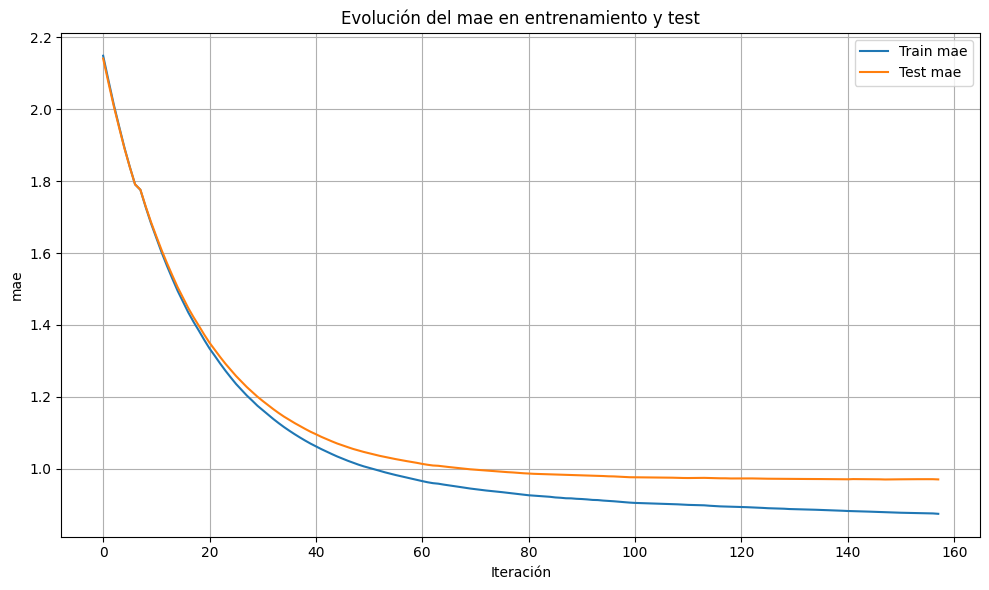

In [ ]:
results = model_puntuacion.evals_result()

# Visualizar la evolución del RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train mae')
plt.plot(results['validation_1']['mae'], label='Test mae')
plt.xlabel("Iteración")
plt.ylabel("mae")
plt.title("Evolución del mae en entrenamiento y test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Predecir sobre TODO el conjunto original
y_pred_total = model_puntuacion.predict(X)

# 2. Asegurarte de que es un array plano (1D)
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# 3. Guardar como nueva columna en el DataFrame original
df_model_puntuacion["Puntuacion_predecida"] = y_pred_total



In [ ]:
df_implantacion = df_model_puntuacion.copy()
from google.colab import files
df_model_puntuacion.to_excel("model_puntuacion.xlsx", index=False)

files.download("model_puntuacion.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Predecir y guardar
df_implantacion=df_model_puntuacion.copy()



In [ ]:
df_implantacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24646 entries, 0 to 24645
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          24646 non-null  int64  
 1   PATIENT BMI                          24646 non-null  float64
 2   ANTIUMULLERIANA_DE                   24646 non-null  float64
 3   N_FOLIC_ANTRAL_DER_IN.-              24646 non-null  int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-              24646 non-null  int64  
 5   DOSIS TOTAL                          24646 non-null  float64
 6   RFA                                  24646 non-null  int64  
 7   ASPIRADOS_PREDICT                    24646 non-null  float64
 8   NIVEL_FSH_H_DE.-_OK                  24646 non-null  int64  
 9   P4_DHCG_DE.-                         24646 non-null  float64
 10  dias_estim_e_cl.-                    24646 non-null  int64  
 11  ampollas_fsh_e_cl.-         

In [ ]:
df_implantacion["Implantacion"]= data["Implantation"]


In [ ]:
df_implantacion.value_counts("Implantacion")

,count
Implantacion,
0.0,411
100.0,354
50.0,85


In [ ]:
data=data['Implantation'].dropna()

In [ ]:
# Filtrar solo los casos con datos de Implantacion
df_implantacion_completo = df_implantacion.dropna(subset=["Implantacion"])

print(f"🔍 Registros completos para Implantacion: {len(df_implantacion_completo)}")


🔍 Registros completos para Implantacion: 850


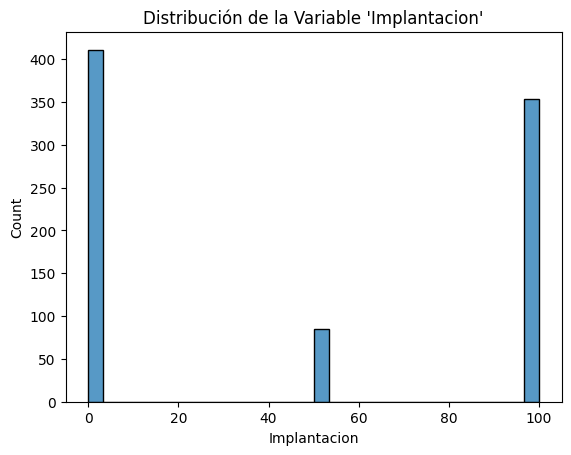

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_implantacion_completo["Implantacion"], bins=30)
plt.title("Distribución de la Variable 'Implantacion'")
plt.show()


<ipython-input-80-c75ad6f0e615>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_implantacion_completo["Implantacion_Binaria"] = df_implantacion_completo["Implantacion"].apply(lambda x: 1 if x >= 50 else 0)


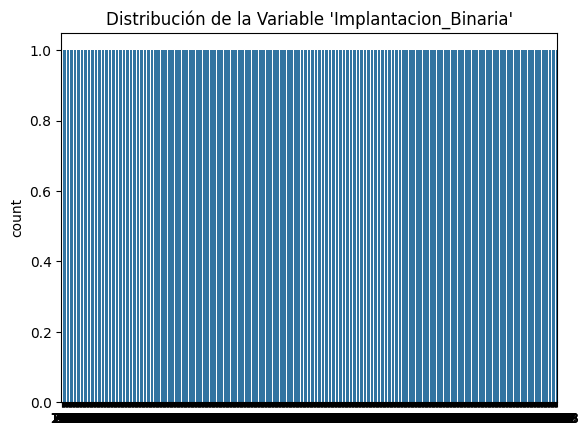

In [ ]:
# Convertir a binario (0 = no implantación, 1 = implantación)
df_implantacion_completo["Implantacion_Binaria"] = df_implantacion_completo["Implantacion"].apply(lambda x: 1 if x >= 50 else 0)

# Verificar la distribución
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_implantacion_completo["Implantacion_Binaria"])
plt.title("Distribución de la Variable 'Implantacion_Binaria'")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

# Filtrar solo los casos con datos completos de implantación
df_completo = df_implantacion_completo.dropna(subset=["Implantacion_Binaria"])

# Separar las variables predictoras y el objetivo
X = df_completo.drop(columns=["Implantacion", "Implantacion_Binaria"])
y = df_completo["Implantacion_Binaria"]

# One-Hot Encoding para variables categóricas
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo",
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio",
    "ESTIMULACIÓN FINAL COD_1",
    "ESTIMULACIÓN FINAL COD_2",
    "ESTIMULACIÓN FINAL COD_3",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-",
    "CALIDAD_PREDICT",
    "iDAScore v2"
]

X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear y entrenar el modelo XGBoost
model_xgb_implantacion = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",  # Usar hist en lugar de gpu_hist
    device="cuda",       # Usar GPU
    early_stopping_rounds=50
)

model_xgb_implantacion.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Evaluar el modelo
y_pred = model_xgb_implantacion.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Accuracy: 0.5470588235294118

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.17      0.27        82
           1       0.54      0.90      0.67        88

    accuracy                           0.55       170
   macro avg       0.57      0.53      0.47       170
weighted avg       0.57      0.55      0.48       170



In [ ]:
# Predecir sobre el conjunto codificado (no uses X, usa X_encoded)
y_pred_total = model_xgb_implantacion.predict(X_encoded)

# Asegúrate de que sea un array plano
y_pred_total = y_pred_total.ravel() if y_pred_total.ndim > 1 else y_pred_total

# Guardar como nueva columna (en el DataFrame sin nulos, que fue el que usaste para entrenar)
df_completo["IMPLANTACION_PREDICT"] = y_pred_total



In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 68 to 26642
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          796 non-null    int64  
 1   PATIENT BMI                          796 non-null    float64
 2   ANTIUMULLERIANA_DE                   796 non-null    float64
 3   N_FOLIC_ANTRAL_DER_IN.-              796 non-null    float64
 4   N_FOLIC_ANTRAL_IZQ_IN.-              796 non-null    float64
 5   DOSIS TOTAL                          796 non-null    float64
 6   RFA                                  796 non-null    float64
 7   ASPIRADOS_PREDICT                    796 non-null    float64
 8   NIVEL_FSH_H_DE.-_OK                  796 non-null    float64
 9   P4_DHCG_DE.-                         796 non-null    float64
 10  dias_estim_e_cl.-                    796 non-null    float64
 11  ampollas_fsh_e_cl.-               

In [ ]:
from google.colab import files
df_completo.to_excel("df_completo.xlsx", index=False)

files.download("df_completo.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cosas que he ehcho viendo que el smote esta generando un oferfiting, cmabiamos los parmatros de XGB_Classifier, paramtros a tenr en cuenta para modifcar:
n_estimator: haciedno que tenga menos tiempo para que no se mememorice los datos y el leraning_rate bajo. Min_child_weiught se usa para definir el número minimo de datos en un nodo para no generar nodos pequeños que puede ser solo ruido,reg_alpha regulariza debido a que elimina los datos que no son importantes, es decir que no contribuyen al error y reg_lambda=10, distribuye los pesos mas uniforme

In [ ]:
import pandas as pd

# Cargar el nuevo archivo Excel
nuevo_df = pd.read_excel("/ruta/al/archivo.xlsx", sheet_name="Nombre_Hoja")
print(nuevo_df.head())


🧠 Cómo Funciona XGBClassifier Internamente (Más Allá de Multiclase)
El XGBClassifier es parte de la biblioteca XGBoost (eX**treme Gradient Boosting), que es uno de los algoritmos de machine learning más potentes para clasificación y regresión. Vamos a explorar cómo funciona internamente:

🔗 1. El Fundamento: Gradient Boosting (GBM)
El Gradient Boosting es un enfoque ensemble que combina muchos árboles de decisión débiles para crear un modelo fuerte. Funciona en varias fases:

Fase 1: Construir un modelo inicial (árbol débil).

Fase 2: Medir los errores de este modelo.

Fase 3: Crear un nuevo modelo que se enfoca en corregir estos errores.

Fase 4: Repetir el proceso hasta que el error sea lo suficientemente bajo o se alcance el número máximo de árboles.

🌱 2. Árboles de Decisión (Base Learners)
Los modelos que crea son árboles de decisión que funcionan de la siguiente manera:

Cada árbol es un conjunto de nodos que dividen los datos en ramas y finalmente en hojas.

Cada hoja representa una predicción para una pequeña parte del espacio de características.

⚙️ 3. Función de Pérdida y Gradientes
XGBoost usa gradientes para ajustar los árboles:

Calcula el error (pérdida) entre las predicciones y los valores reales.

Usa este error para ajustar los pesos de los árboles en las siguientes iteraciones.

Los árboles siguientes están "dirigidos" a corregir los errores de los árboles anteriores.

🔗 4. Cálculo del Error y Actualización de los Pesos
Pérdida (eval_metric):

Binario: logloss

Multiclase: mlogloss

Optimización del Error:

Se usa el método de gradiente descendente para ajustar los pesos.

¡
Donde:

y_i es el valor real.

\hat{y_i} es la predicción.

w son los pesos de las hojas.

\lambda y \alpha son los términos de regularización para evitar overfitting.

🛠️ 5. Regularización (reg_alpha, reg_lambda)
reg_alpha (L1 Regularización): Penaliza las características menos importantes, reduciendo el sobreajuste.

reg_lambda (L2 Regularización): Hace que los pesos de las hojas sean más pequeños y distribuidos, también reduciendo el sobreajuste.

🔄 6. Creación de los Árboles (Tree Boosting)
Criterio de División: Elige la característica que maximiza la ganancia de información en cada nodo.

Poda de Árboles: Remueve nodos que no contribuyen significativamente a la precisión.

Colapso de Nodos: Si un nodo no tiene suficientes ejemplos (min_child_weight), no se divide.

📦 7. Construcción Rápida de Árboles (tree_method)
XGBoost usa métodos avanzados para construir los árboles rápidamente:

Exact: Recorre todos los posibles puntos de división (lento para muchos datos).

Approx: Usa histogramas para acelerar las divisiones.

Hist: Más rápido y eficiente en memoria.

GPU_Hist: Usa GPU para acelerar aún más.

📝 8. Early Stopping y Overfitting
Early Stopping: Detiene el entrenamiento si el error en el conjunto de validación deja de mejorar.

Regularización: Evita que los árboles se ajusten demasiado a ejemplos específicos.

🔗 9. Predicción Final (Ensamblaje)
El modelo final es la suma ponderada de todos los árboles:


Cada árbol f_t corrige los errores de los árboles anteriores.

Las salidas se combinan para hacer una predicción final más precisa.

📊 10. Salida del Modelo:
predict() para valores finales.

predict_proba() para probabilidades de cada clase (en multiclase).

feature_importances_ para identificar las características más importantes.



In [ ]:
import pandas as pd

df_transferidos = pd.read_excel("/content/model_puntuacion (1).xlsx")

df_transferidos.head(5)

,PATIENT AGE,PATIENT BMI,ANTIUMULLERIANA_DE,N_FOLIC_ANTRAL_DER_IN.-,N_FOLIC_ANTRAL_IZQ_IN.-,DOSIS TOTAL,RFA,ASPIRADOS_PREDICT,NIVEL_FSH_H_DE.-_OK,P4_DHCG_DE.-,...,CALIDAD_PREDICT,iDAScore v2,OVO_MII_INSEMIN_IN.-_OK_GRUPO_Alto,OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo,OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio,ESTIMULACIÓN FINAL COD_0,ESTIMULACIÓN FINAL COD_1,ESTIMULACIÓN FINAL COD_2,ESTIMULACIÓN FINAL COD_3,Puntuacion_predecida
0,35,24.13,14.52,7,6,4100.0,13,12.119667,0,1.4,...,1,1.1,False,False,True,False,True,False,False,1.058097
1,35,24.13,14.52,7,6,4100.0,13,12.622733,0,1.4,...,1,1.1,False,False,True,False,True,False,False,1.130990
2,35,24.13,14.52,7,6,4100.0,13,12.622733,0,1.4,...,1,1,False,False,True,False,True,False,False,1.130990
3,35,24.13,14.52,7,6,4100.0,13,12.119667,0,1.4,...,2,2.4,False,False,True,False,True,False,False,2.352962
4,35,24.13,14.52,7,6,4100.0,13,12.119667,0,1.4,...,1,1.4,False,False,True,False,True,False,False,1.029469


In [ ]:
df_transferidos["Implantation"]=data["Implantation"]
df_transferidos["Implantation_cong"]=data["tCong_Implant"]

In [ ]:
# Casos con datos de implantación reales
df_transferidos_filtados_impla = df_transferidos[
    (df_transferidos["Implantation"].notna()) |
    (df_transferidos["Implantation_cong"].notna())
].copy()


In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"] = ((df_transferidos_filtados_impla["Implantation"] > 0) | (df_transferidos_filtados_impla["Implantation_cong"] > 0)).astype(int)

In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"] .value_counts()

,count
IMPLANTACION_final,
1,1813
0,1593


In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"]  = df_transferidos_filtados_impla["IMPLANTACION_final"].apply(lambda x: "NV" if x == 0 else "IMPLANTADO")


In [ ]:
df_transferidos_filtados_impla["IMPLANTACION_final"].value_counts()

,count
IMPLANTACION_final,
IMPLANTADO,1813
NV,1593


In [ ]:
df_transferidos_filtados_impla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3406 entries, 3 to 24628
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT AGE                          3406 non-null   int64  
 1   PATIENT BMI                          3406 non-null   float64
 2   ANTIUMULLERIANA_DE                   3406 non-null   float64
 3   N_FOLIC_ANTRAL_DER_IN.-              3406 non-null   int64  
 4   N_FOLIC_ANTRAL_IZQ_IN.-              3406 non-null   int64  
 5   DOSIS TOTAL                          3406 non-null   float64
 6   RFA                                  3406 non-null   int64  
 7   ASPIRADOS_PREDICT                    3406 non-null   float64
 8   NIVEL_FSH_H_DE.-_OK                  3406 non-null   int64  
 9   P4_DHCG_DE.-                         3406 non-null   float64
 10  dias_estim_e_cl.-                    3406 non-null   int64  
 11  ampollas_fsh_e_cl.-               

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Separar las variables predictoras y el objetivo
X = df_transferidos_filtados_impla.drop(columns=["Implantation", "Implantation_cong", "IMPLANTACION_final"])
# Convertir "IMPLANTADO"/"NV" a binario para el modelo
y = df_transferidos_filtados_impla["IMPLANTACION_final"].apply(lambda x: 1 if x == "IMPLANTADO" else 0)



# Columnas categóricas para aplicar One-Hot Encoding
columnas_categoricas = [
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Bajo",
    "OVO_MII_INSEMIN_IN.-_OK_GRUPO_Medio",
    "ESTIMULACIÓN FINAL COD_1",
    "ESTIMULACIÓN FINAL COD_2",
    "ESTIMULACIÓN FINAL COD_3",
    "d2_celulas.-",
    "d3_celulas.-",
    "dia5.-",
    "CALIDAD_PREDICT",
    "iDAScore v2"
]

# Codificación One-Hot (elimina la primera categoría para evitar multicolinealidad)
X_encoded = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# --- 2. Dividir datos ---

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, stratify=y, test_size=0.2, random_state=42
)

# --- 3. Entrenar modelo XGBoost ---

model_xgb_implantacion_final = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",  # usa "gpu_hist" si usas GPU
    device="cuda",       # o elimina si no usas GPU
    early_stopping_rounds=50
)

model_xgb_implantacion_final.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# --- 4. Evaluar modelo ---

y_pred = model_xgb_implantacion_final.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:30:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:30:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



Accuracy: 0.5674486803519062

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.30      0.39       319
           1       0.57      0.80      0.66       363

    accuracy                           0.57       682
   macro avg       0.57      0.55      0.53       682
weighted avg       0.57      0.57      0.54       682



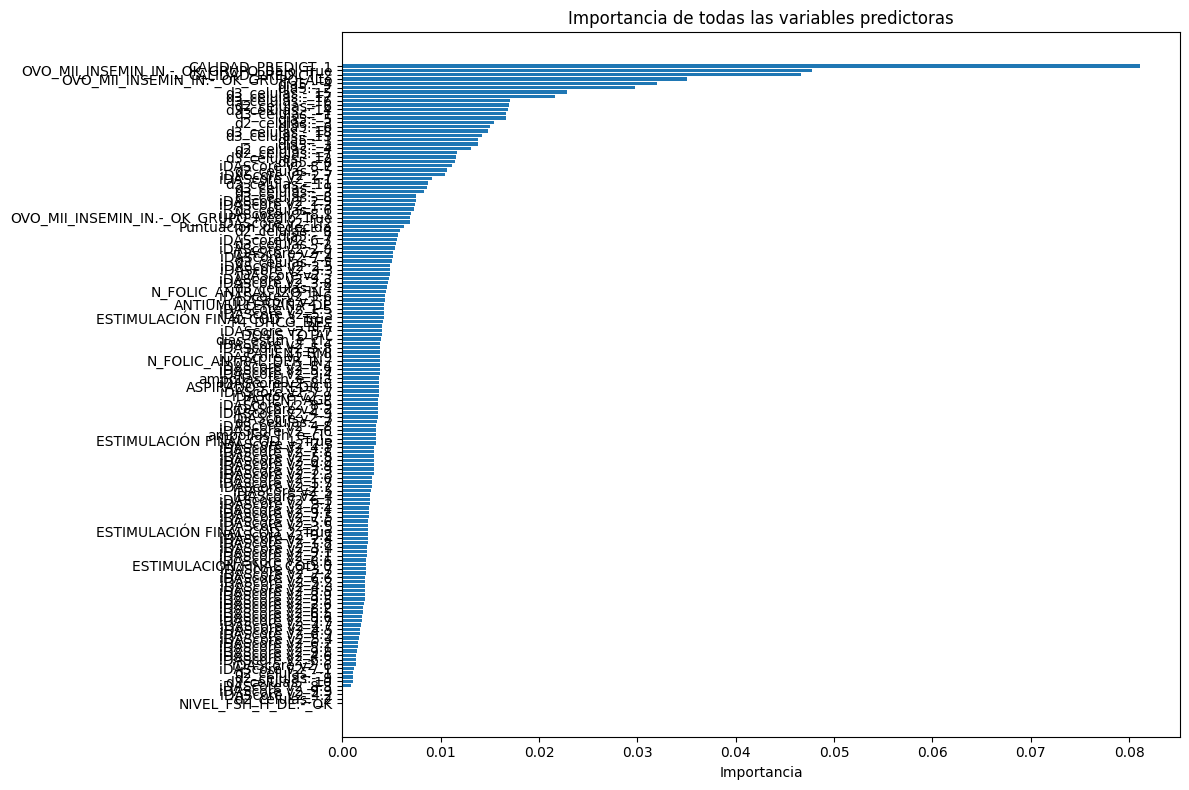

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener importancia de características
xgb_feat_importance = model_xgb_implantacion.feature_importances_
sorted_idx = np.argsort(xgb_feat_importance)[::-1]
top_features = X_train_resampled.columns[sorted_idx]

# Gráfico de barras horizontal con todas las variables
plt.figure(figsize=(12,8))
plt.barh(top_features, xgb_feat_importance[sorted_idx])
plt.xlabel("Importancia")
plt.title("Importancia de todas las variables predictoras")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(14605), np.int64(1): np.int64(14605)}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Get the best model from the grid search
best_model = grid_xgb.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))